In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


import pickle

import deepdiff


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(1)


blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)

In [2]:
from src.model_simple import SSCNetwork
from src.utils.general import make_input, LatentSpace, get_ordered_indices, test_network
from src.utils.general_old import get_selectivity, get_cos_sim_torch

from network_parameters import network_parameters

from Figure_5_utils import blocked_interleaved

In [3]:
#make network randomly project sensory input to obtain a wide distribution of selectivity in MTL-sensory
network_parameters["mtl_dense_sen_projection"] = True
network_parameters["mtl_dense_sen_size"] = 30
network_parameters["max_post_mtl_dense_sen"] = 1
network_parameters["max_pre_mtl_dense_sen"] = np.inf

In [4]:
recording_parameters = {}
recording_parameters["regions"] = ["mtl_dense", "mtl_sparse", "mtl", "ctx"]
recording_parameters["rate_activity"] = np.inf
recording_parameters["connections"] = ["ctx_mtl"]
recording_parameters["rate_connectivity"] = np.inf


network_parameters["mtl_mtl_lmbda"] = 5e-3
network_parameters["max_pre_mtl_mtl"] = np.inf
network_parameters["max_post_mtl_mtl"] = np.inf

network_parameters["mtl_dense_mtl_dense_lmbda"] = 5e-3
network_parameters["max_pre_mtl_dense_mtl_dense"] = np.inf
network_parameters["max_post_mtl_dense_mtl_dense"] = np.inf

network_parameters["mtl_sparse_mtl_sparse_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_mtl_sparse"] = np.inf
network_parameters["max_post_mtl_sparse_mtl_sparse"] = np.inf


input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4


latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]

In [5]:
network, input, input_latents, input_episodes, ordered_indices_ctx, ordered_indices_mtl_dense, ordered_indices_mtl_sparse, selectivity_ctx, selectivity_mtl_dense, selectivity_mtl_sparse, accuracy = blocked_interleaved(network_parameters, recording_parameters, input_params, latent_specs, training='blocked', seed=90, get_network=True)

starting simulation blocked - 90
0
0
0
0
0
0
0
0
0
0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
0
50


In [9]:
network.selectivity_ctx, network.ordered_indices_ctx = selectivity_ctx, ordered_indices_ctx
network.selectivity_mtl_sparse, network.ordered_indices_mtl_sparse = selectivity_mtl_sparse, ordered_indices_mtl_sparse
network.selectivity_mtl_dense, network.ordered_indices_mtl_dense = selectivity_mtl_dense, ordered_indices_mtl_dense

In [32]:
def forward(self, input, debug=False):
    #this resests the network quick connections at the beginning of each day
    if self.reset_dayly:
        self.mtl_mtl = torch.zeros((self.mtl_size, self.mtl_size))
        self.mtl_sparse_mtl_sparse = torch.zeros((self.mtl_sparse_size, self.mtl_sparse_size))
        self.mtl_dense_mtl_dense =  torch.zeros((self.mtl_dense_size, self.mtl_dense_size))

      
    #iterate over every timestep in the input sequence (day)
    for timestep in range(input.shape[0]):
        
        #activate sensory
        self.sen, _ = self.activation(input[timestep], 'sen')

        #sensory to mtl_dense
        self.mtl_dense_hat = F.linear(self.sen, self.mtl_dense_sen)
        self.mtl_dense, _ = self.activation(self.mtl_dense_hat, 'mtl_dense')

        #mtl_sparse is initialized at random
        self.mtl_sparse_hat = torch.randn(self.mtl_sparse_size)
        self.mtl_sparse, _ = self.activation(self.mtl_sparse_hat, 'mtl_sparse')

        #set full mtl
        self.mtl[:self.mtl_dense_size] = self.mtl_dense
        self.mtl[self.mtl_dense_size:] = self.mtl_sparse

        '''
        #mtl to ctx
        self.ctx_hat = F.linear(self.mtl, self.ctx_mtl) + self.ctx_b*self.ctx_IM
        self.ctx, _ = self.activation(self.ctx_hat, 'ctx')
        '''
        #'''
        #mtl to ctx
        self.ctx_hat = F.linear(self.mtl[:self.mtl_dense_size], self.ctx_mtl[:, :self.mtl_dense_size]) + self.ctx_b*self.ctx_IM
        self.ctx, _ = self.activation(self.ctx_hat, 'ctx')
        #'''


        #if CTX is developed (after phase A), pattern complete ctx and ctx to mtl_sparse
        if self.day >= self.duration_phase_A:
            self.ctx = self.pattern_complete('ctx', self.ctx)
            self.mtl_sparse_hat = F.linear(self.ctx, self.mtl_sparse_ctx) + self.mtl_sparse_b*self.mtl_sparse_IM
            self.mtl_sparse, _ = self.activation(self.mtl_sparse_hat, 'mtl_sparse')
            self.mtl[self.mtl_dense_size:] = self.mtl_sparse

          #only after phase A mtl_sparse_mtl_sparse is used
            self.hebbian('mtl_sparse', 'mtl_sparse')
            self.homeostasis('mtl_sparse', 'mtl_sparse')

        #if MTL is developed (after phase B), mtl_sparse to ctx
        if self.day >= self.duration_phase_B:
            self.ctx_hat = F.linear(self.mtl, self.ctx_mtl)
            self.ctx, _ = self.activation(self.ctx_hat, 'ctx')


        #learn mtl_mtl, mtl_dense_mtl_dense and ctx_ctx

        self.hebbian('mtl', 'mtl')
        self.homeostasis('mtl', 'mtl')

        self.hebbian('mtl_dense', 'mtl_dense')
        self.homeostasis('mtl_dense', 'mtl_dense')

        self.hebbian('ctx', 'ctx')
        self.homeostasis('ctx', 'ctx')

        self.record()
        self.time_index += 1
        self.awake_indices.append(self.time_index)
    self.day += 1



def sleep(self):

  #sleep has two phases, episodic replay and semantic replay
  
  #we start with episodic replay
  for timestep in range(self.sleep_duration_A):
    #if mtl_sparse is not developed (before duration phase B), we use mtl_dense
    if self.day <= self.duration_phase_B:
      mtl_dense_random = torch.randn(self.mtl_dense_size)**2
      self.mtl_dense = self.pattern_complete('mtl_dense', h_0=mtl_dense_random, sleep=True)
      self.mtl[:self.mtl_dense_size] = self.mtl_dense
      self.mtl[self.mtl_dense_size:] = 0
      self.ctx_hat = F.linear(self.mtl, self.ctx_mtl) + self.ctx_b*self.ctx_IM
      self.ctx, _ = self.activation(self.ctx_hat, 'ctx', subregion_index=0, sleep=True)

      self.hebbian('ctx', 'mtl')
      self.homeostasis('ctx', 'mtl')

      #if self.day >= self.duration_phase_A:
      #      self.ctx = self.pattern_complete('ctx', self.ctx, sleep=True)

    else:
      semantic_charge = torch.randint(low=1, high=self.max_semantic_charge_replay+1, size=(1,))[0]
      self.mtl = self.mtl_generate(semantic_charge)
      self.ctx_hat = F.linear(self.mtl, self.ctx_mtl) + self.ctx_b*self.ctx_IM
      self.ctx, _ = self.activation(self.ctx_hat, 'ctx', subregion_index=semantic_charge-1, sleep=True)

      self.hebbian('ctx', 'mtl')
      self.homeostasis('ctx', 'mtl')


    #self.hebbian('ctx', 'ctx')
    #self.homeostasis('ctx', 'ctx')

    self.record()
    self.time_index += 1
    self.sleep_indices_A.append(self.time_index)

  if self.day >= self.duration_phase_A:

    for timestep in range(self.sleep_duration_B):

      ctx_random = torch.randn(self.ctx_size)
      self.ctx = self.pattern_complete('ctx', h_0=ctx_random, subregion_index=0, sleep=True)

      self.mtl_sparse_hat = F.linear(self.ctx, self.mtl_sparse_ctx) + self.mtl_sparse_b*self.mtl_sparse_IM
      self.mtl_sparse, _ = self.activation(self.mtl_sparse_hat, 'mtl_sparse', sleep=True)
      self.mtl[self.mtl_dense_size:] = self.mtl_sparse

      self.hebbian('mtl_sparse', 'ctx')
      self.homeostasis('mtl_sparse', 'ctx')

      self.record()
      self.time_index += 1
      self.sleep_indices_B.append(self.time_index)




def mtl_generate(self, semantic_charge, num_iterations=None):
    num_iterations = num_iterations  if num_iterations != None else getattr(self, 'mtl_generate_pattern_complete_iterations')
    #mtl_sparse_sparsity = (semantic_charge/self.max_semantic_charge_input)*self.mtl_sparse_sparsity.clone()
    #h_random_sparse = torch.randn(self.mtl_sparse_size)**2
    #h_sparse = self.pattern_complete('mtl_sparse', h_0=h_random_sparse, num_iterations=num_iterations, sparsity=mtl_sparse_sparsity)
    mtl_sparsity = (semantic_charge/self.max_semantic_charge_input)*self.mtl_sparsity.clone()
    #h_conditioned = torch.zeros(self.mtl_size)
    #h_conditioned[self.mtl_dense_size:] = h_sparse
    h_random = torch.randn(self.mtl_size)
    #h_random[self.mtl_dense_size:] = h_sparse
    h = self.pattern_complete('mtl', h_0=h_random, h_conditioned=None, num_iterations=num_iterations, sparsity=mtl_sparsity)
    return h

In [33]:
#torch.save(network, "checkpoints/network_7_random.pt")


#network = torch.load("checkpoints/network_5_blocked.pt", weights_only=False)
#network = torch.load("checkpoints/network_5_blocked_swaps_4.pt", weights_only=False)
network = torch.load("checkpoints/network_5_blocked_c.pt", weights_only=False)

In [34]:
import types

# Bind it to *this* instance
#network.sleep = types.MethodType(sleep, network)


# Bind it to *this* instance
network.forward = types.MethodType(forward, network)
network.mtl_generate = types.MethodType(mtl_generate, network)

(array([50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  5.,  5.,  0.,  5.,  0.,  0.,  0.,  0., 10.,  5.,  0.,  5.,
         0.,  5.,  0.,  0.,  5.,  0.,  0.,  0.,  5.]),
 array([0.        , 0.00975829, 0.01951659, 0.02927488, 0.03903317,
        0.04879146, 0.05854976, 0.06830805, 0.07806634, 0.08782464,
        0.09758293, 0.10734122, 0.11709952, 0.1268578 , 0.1366161 ,
        0.14637439, 0.15613268, 0.16589098, 0.17564927, 0.18540756,
        0.19516586, 0.20492415, 0.21468244, 0.22444074, 0.23419903,
        0.24395733, 0.2537156 , 0.2634739 , 0.27323219, 0.28299049,
        0.29274878, 0.3025

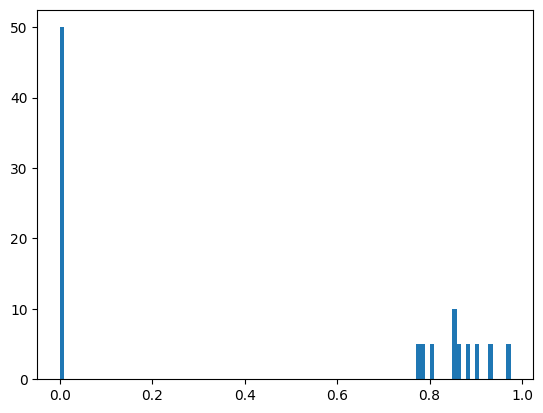

In [30]:
plt.hist((network.selectivity_mtl_sparse.max(axis=1)[0]).flatten(), bins=100)

In [6]:
network.duration_phase_B = 1000

In [29]:
network.max_semantic_charge_replay = 2
network.init_recordings(recording_parameters)
network.frozen = False
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf


# Generate independent permutations for each row
perms = torch.argsort(torch.rand_like(network.mtl_sparse_ctx), dim=1)
# Apply the permutations
network.mtl_sparse_ctx = torch.gather(network.mtl_sparse_ctx, dim=1, index=perms)
# Freeze ctx to mtl sparse connections
network.mtl_sparse_ctx_lmbda = 0
network.mtl_sparse_b[:] = -1




input_params["num_days"] = 100
input_params["day_length"] = 10
input_params["mean_duration"] = 5
input_params["num_swaps"] = 4
#latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]

input_params["latent_space"] = LatentSpace(**latent_specs)



input, input_episodes, input_latents = make_input(**input_params)


sleep = True
print_rate = 50
with torch.no_grad():
    for day in range(input_params["num_days"]):
        if day%print_rate == 0:
            print(day)
        network(input[day], debug=False)
        if sleep:
            network.sleep()

0
50


In [62]:
network.max_semantic_charge_replay = 2
network.init_recordings(recording_parameters)
network.frozen = False
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf



# Generate independent permutations for each row
perms = torch.argsort(torch.rand_like(network.mtl_sparse_ctx), dim=1)
# Apply the permutations
network.mtl_sparse_ctx = torch.gather(network.mtl_sparse_ctx, dim=1, index=perms)
# Freeze ctx to mtl sparse connections
network.mtl_sparse_ctx_lmbda = 0
network.mtl_sparse_b[:] = -1



input_params["num_days"] = 1
input_params["day_length"] = 25
input_params["mean_duration"] = 5
input_params["num_swaps"] = 4


#latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]

for episode in range(25):
    latent_specs["prob_list"] = [0 for i in range(5) for j in range(5)]
    latent_specs["prob_list"][episode] = 1
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents = make_input(**input_params)


    sleep = True
    print_rate = 50
    with torch.no_grad():
        for day in range(input_params["num_days"]):
            if day%print_rate == 0:
                print(day)
            network(input[day], debug=False)
            if sleep:
                network.sleep()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [35]:
network.max_semantic_charge_replay = 1
network.init_recordings(recording_parameters)
network.frozen = False
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf


'''
# Generate independent permutations for each row
perms = torch.argsort(torch.rand_like(network.mtl_sparse_ctx), dim=1)
# Apply the permutations
network.mtl_sparse_ctx = torch.gather(network.mtl_sparse_ctx, dim=1, index=perms)
# Freeze ctx to mtl sparse connections
network.mtl_sparse_ctx_lmbda = 0
network.mtl_sparse_b[:] = -1
'''



input_params["num_days"] = 500
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["num_swaps"] = 4
#latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]

input_params["latent_space"] = LatentSpace(**latent_specs)



input, input_episodes, input_latents = make_input(**input_params)


sleep = True
print_rate = 50
with torch.no_grad():
    for day in range(input_params["num_days"]):
        if day%print_rate == 0:
            print(day)
        network(input[day], debug=False)
        if sleep:
            network.sleep()

0
50
100
150
200
250
300
350
400
450


In [36]:
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

X_episodes = F.one_hot(input_episodes[-100:].long(), num_classes=np.prod(latent_specs["dims"]))


network.selectivity_ctx, network.ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)
network.selectivity_mtl_sparse, network.ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, assembly_size=5)
network.selectivity_mtl_dense, network.ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, assembly_size=10)
network.selectivity_ctx_episodes, network.ordered_indices_ctx_episodes = get_ordered_indices(X_ctx, X_episodes, assembly_size=10)

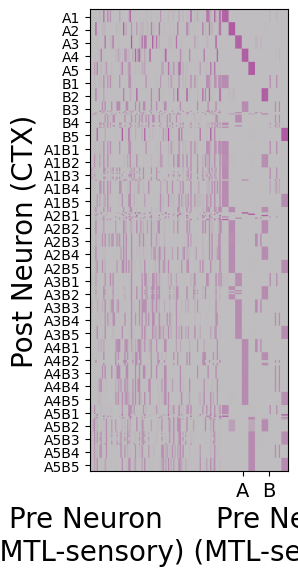

In [37]:
full_ordered_indices_ctx = torch.cat([
    network.ordered_indices_ctx[:100],
    network.ordered_indices_ctx_episodes[:250]
])


# Compute the full indexing array
full_ordered_indices = torch.cat([
    torch.arange(100),
    network.mtl_dense_size + network.ordered_indices_mtl_sparse
])


fig = plt.figure(figsize=(5, 6))

plt.imshow(network.ctx_mtl[full_ordered_indices_ctx][:, full_ordered_indices[:150]], cmap=gray_purple)


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]


# Example parameters
N = 250  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [100 + M * (k + 0.5) for k in range(NA * NB)]

positions.extend(positions_episodes)
labels.extend(labels_episodes)

plt.yticks(positions, labels)

plt.xticks([115, 135], ["A", "B"],  fontsize=14)
plt.xlabel("Pre Neuron      Pre Neuron\n  (MTL-sensory) (MTL-semantic)", fontsize=20)
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.savefig('Figures_SVG/7d.svg', dpi=300, transparent=True)


In [13]:
torch.mean(network.selectivity_ctx_episodes[network.ordered_indices_ctx_episodes].max(axis=1)[0][:250])

tensor(0.7835)

([<matplotlib.axis.XTick at 0x36632afd0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

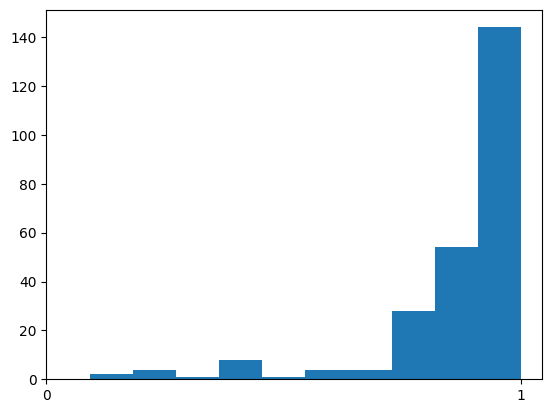

In [24]:
plt.hist(network.selectivity_ctx_episodes[network.ordered_indices_ctx_episodes[:250]].max(axis=1)[0])
plt.xticks([0, 1])

([<matplotlib.axis.XTick at 0x38e91b2e0>,
 [Text(0.0, 0, '0.0'), Text(0.7, 0, '0.7'), Text(1.0, 0, '1.0')])

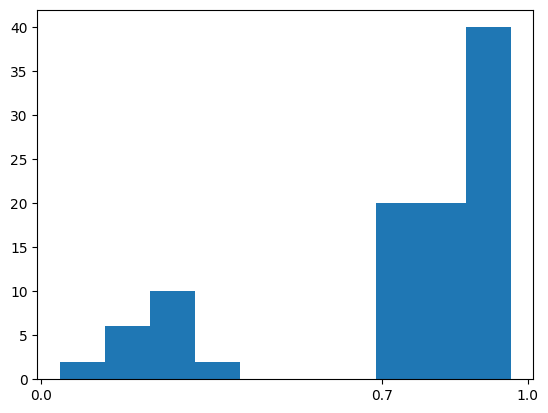

In [38]:
plt.hist(network.selectivity_ctx[network.ordered_indices_ctx[:100]].max(axis=1)[0])
plt.xticks([0, 0.7, 1])

(array([ 5.,  5.,  0.,  0.,  5.,  5.,  0., 10.,  5., 15.]),
 array([0.89312595, 0.90303892, 0.91295189, 0.92286485, 0.93277782,
        0.94269085, 0.95260382, 0.96251678, 0.97242975, 0.98234272,
        0.99225569]),
 <BarContainer object of 10 artists>)

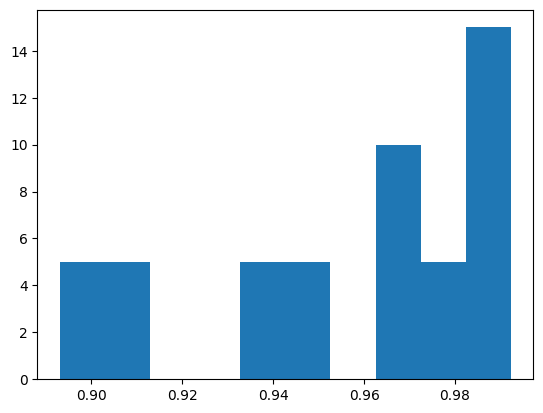

In [49]:
plt.hist(network.selectivity_mtl_sparse[network.ordered_indices_mtl_sparse[:50]].max(axis=1)[0])

([<matplotlib.axis.XTick at 0x315d799d0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

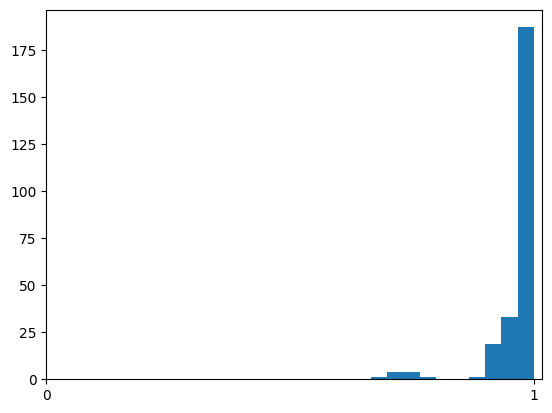

In [36]:
plt.hist(network.selectivity_ctx_episodes[network.ordered_indices_ctx_episodes[:250]].max(axis=1)[0])
plt.xticks([0, 1])

([<matplotlib.axis.XTick at 0x362411f40>,
 [Text(0.0, 0, '0.0'), Text(0.7, 0, '0.7'), Text(1.0, 0, '1.0')])

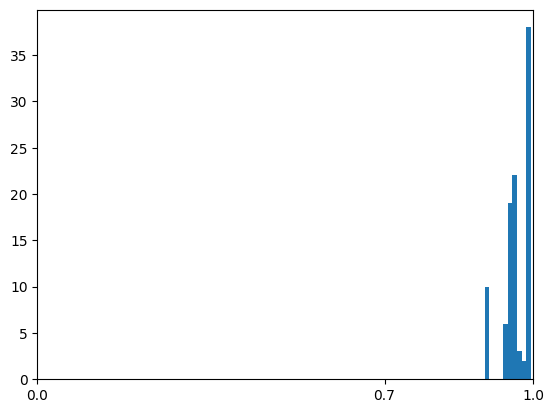

In [37]:
plt.hist(network.selectivity_ctx[network.ordered_indices_ctx[:100]].max(axis=1)[0])
plt.xticks([0, 0.7, 1])

([<matplotlib.axis.XTick at 0x37f6c2a30>,
 [Text(0.0, 0, '0.0'), Text(0.7, 0, '0.7'), Text(1.0, 0, '1.0')])

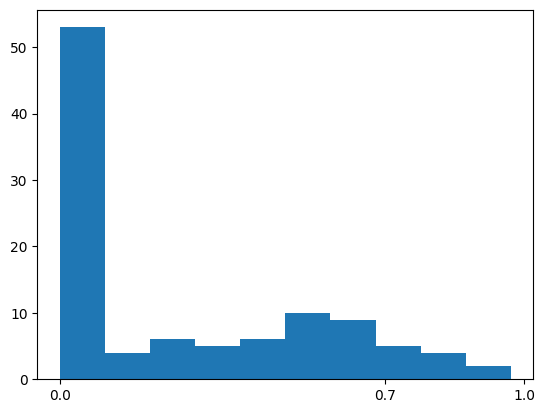

In [38]:
plt.hist(network.selectivity_mtl_sparse[network.ordered_indices_mtl_sparse[:150]].max(axis=1)[0])
plt.xticks([0, 0.7, 1])

In [43]:
network.selectivity_ctx[network.ordered_indices_ctx[:100]].max(axis=1)[0]

tensor([0.9305, 0.9305, 0.9305, 0.9305, 0.9305, 0.9305, 0.9305, 0.9305, 0.9305,
        0.9305, 0.9835, 0.9835, 0.9835, 0.9835, 0.9835, 0.9835, 0.9835, 0.9835,
        0.9835, 0.9835, 0.9382, 0.9382, 0.9382, 0.9382, 0.9387, 0.9387, 0.9382,
        0.9387, 0.9387, 0.9387, 0.9814, 0.9810, 0.9814, 0.9810, 0.9814, 0.9810,
        0.9810, 0.9814, 0.9810, 0.9814, 0.9792, 0.9792, 0.9792, 0.9792, 0.9792,
        0.9792, 0.9792, 0.9792, 0.9792, 0.9792, 0.9935, 0.9935, 0.9935, 0.9935,
        0.9935, 0.9935, 0.9935, 0.9935, 0.9935, 0.9935, 0.9572, 0.9572, 0.9572,
        0.9572, 0.9572, 0.9572, 0.9572, 0.9572, 0.9572, 0.9572, 0.9820, 0.9815,
        0.9815, 0.9815, 0.9815, 0.9815, 0.9815, 0.9820, 0.9815, 0.9815, 0.9757,
        0.9761, 0.9761, 0.9757, 0.9757, 0.9757, 0.9757, 0.9757, 0.9760, 0.9757,
        0.9253, 0.9253, 0.9253, 0.9253, 0.9253, 0.9253, 0.9253, 0.9257, 0.9253,
        0.9253])

([<matplotlib.axis.XTick at 0x37f59eaf0>,
 [Text(0.0, 0, '0.0'), Text(0.7, 0, '0.7'), Text(1.0, 0, '1.0')])

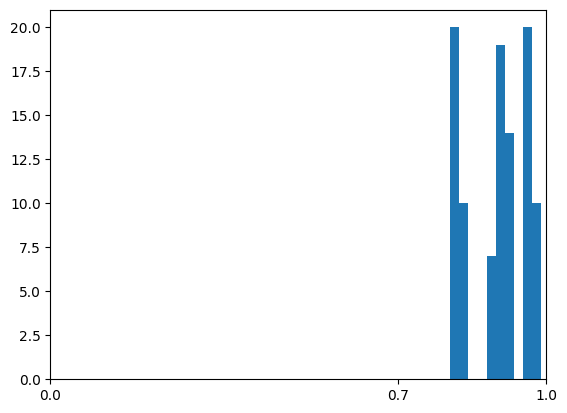

([<matplotlib.axis.XTick at 0x392304ac0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

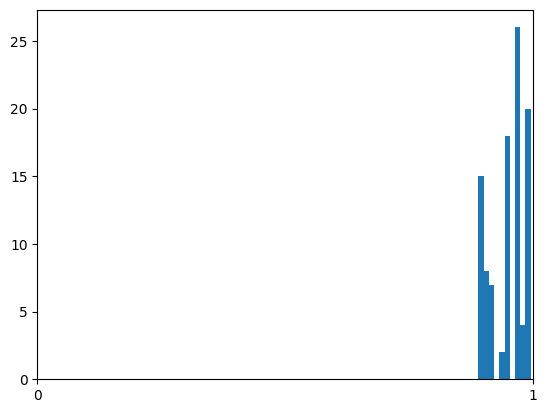

In [52]:
plt.hist(network.selectivity_ctx[network.ordered_indices_ctx[:100]].max(axis=1)[0])
plt.xticks([0, 1])

([<matplotlib.axis.XTick at 0x37e2830d0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

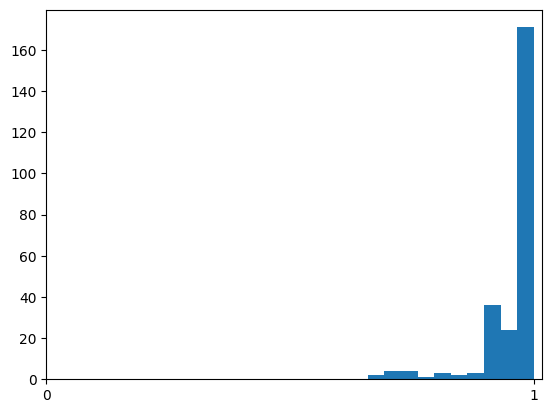

In [51]:
plt.hist(network.selectivity_ctx_episodes[network.ordered_indices_ctx_episodes[:250]].max(axis=1)[0])
plt.xticks([0, 1])

(array([  6.,   0.,   0.,   0.,   0.,   0.,   4.,  33.,  21., 186.]),
 array([0.        , 0.09953401, 0.19906802, 0.29860204, 0.39813605,
        0.49767005, 0.59720409, 0.69673806, 0.7962721 , 0.89580607,
        0.99534011]),
 <BarContainer object of 10 artists>)

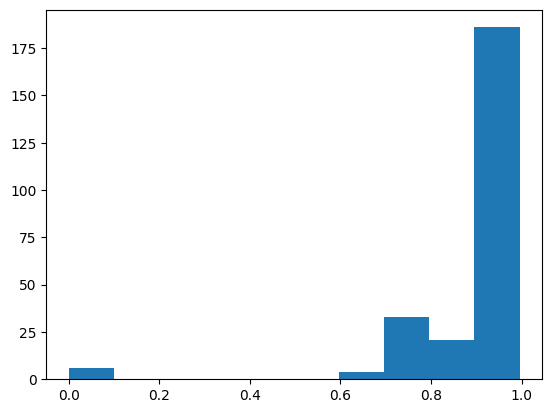

In [47]:
plt.hist(network.selectivity_ctx_episodes[network.ordered_indices_ctx_episodes[:250]].max(axis=1)[0])

(array([[250.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 30.,  20.,  30.,  20.,  20.,  30.,  20.,  30.,  20.,  30.]]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 2 BarContainer objects>)

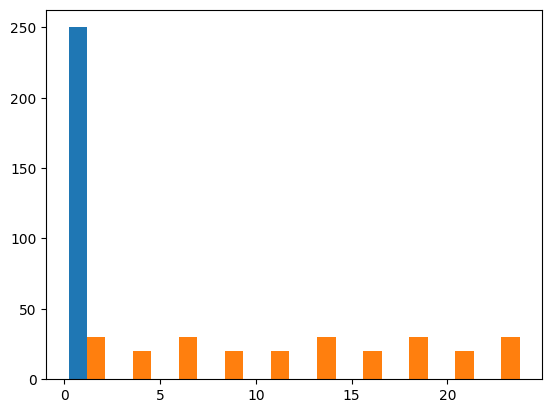

In [12]:
plt.hist(network.selectivity_ctx_episodes[network.ordered_indices_ctx_episodes[:250]].max(axis=1))

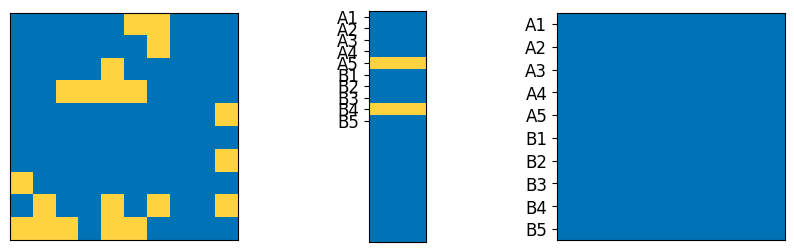

In [97]:



index = 12


mtl = torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A]
ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A]

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(mtl[index, :100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl[index, 100:][network.ordered_indices_mtl_sparse[:100]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx[index, network.ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]

ax[2].set_yticks(positions, labels, fontsize=12)

([<matplotlib.axis.YTick at 0x3833a96d0>,
 [Text(0, 0, 'A1'),
  Text(0, 1, 'A2'),
  Text(0, 2, 'A3'),
  Text(0, 3, 'A4'),
  Text(0, 4, 'A5'),
  Text(0, 5, 'B1'),
  Text(0, 6, 'B2'),
  Text(0, 7, 'B3'),
  Text(0, 8, 'B4'),
  Text(0, 9, 'B5')])

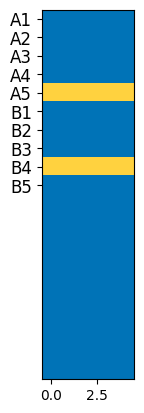

In [98]:



index = 12


mtl = torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A]
ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A]



plt.imshow(mtl[index, 100:][network.ordered_indices_mtl_sparse[:100]].reshape((-1, 5)), cmap=blue_yellow)

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


plt.yticks(positions, labels, fontsize=12)

In [101]:
torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A].shape

torch.Size([5000, 200])

IndexError: list index out of range

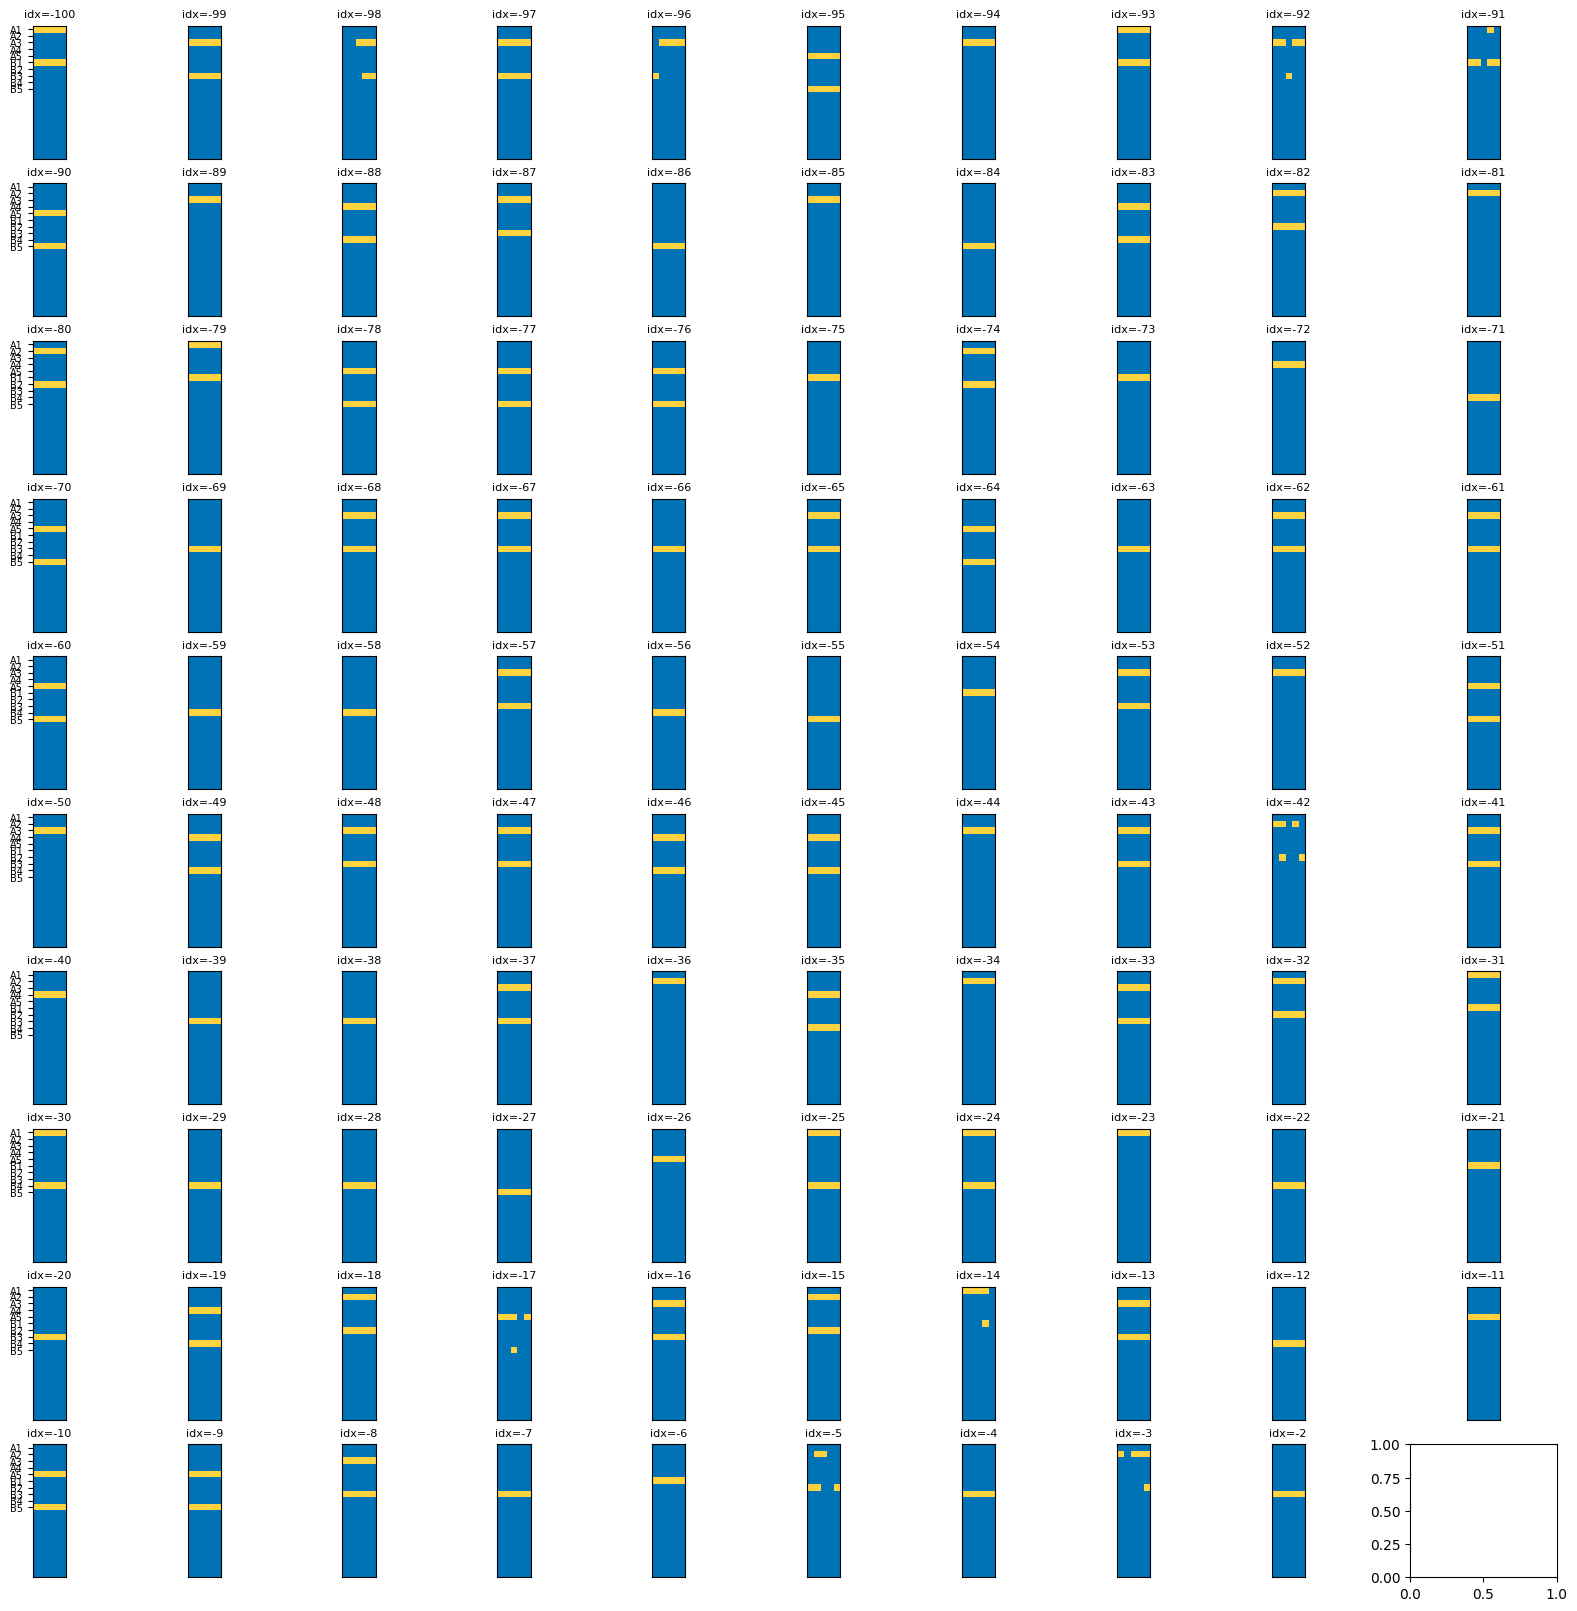

In [111]:
import torch
import matplotlib.pyplot as plt

# Choose any 100-index range
start_idx = -100
end_idx   =   -1 # must be start_idx + 100 for a 10x10 grid

# Build tensors
mtl = torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A]
ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A]

ordered_idx = network.ordered_indices_mtl_sparse[:100]

# Precompute images
imgs = []
for idx in range(start_idx, end_idx):
    img = mtl[idx, 100:][ordered_idx].reshape((-1, 5))
    imgs.append(img)

# Get consistent vmin/vmax for color scaling
vmin = torch.stack([im.min() for im in imgs]).min().item()
vmax = torch.stack([im.max() for im in imgs]).max().item()

# Label parameters
N  = 10  # total y ticks (0..N)
NA = 5   # number of A groups
NB = 5   # number of B groups
M  = N // (NA + NB)
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
positions = [M * i for i in range(NA + NB)]

# Plot grid
fig, axes = plt.subplots(10, 10, figsize=(16, 16), constrained_layout=True)

for i, ax in enumerate(axes.ravel()):
    im = ax.imshow(imgs[i], cmap=blue_yellow, vmin=vmin, vmax=vmax)
    ax.set_title(f"idx={start_idx + i}", fontsize=8)
    ax.set_xticks([])

    if i % 10 == 0:
        ax.set_yticks(positions)
        ax.set_yticklabels(labels, fontsize=7)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

fig.colorbar(im, ax=axes, fraction=0.02, pad=0.01).ax.tick_params(labelsize=8)
plt.show()

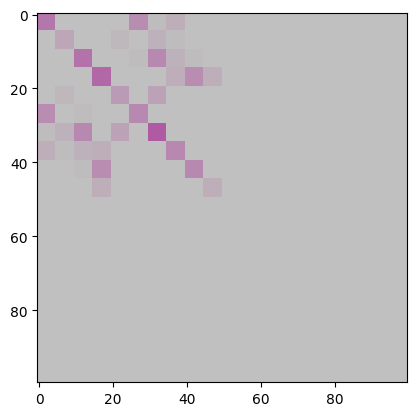

In [25]:
plt.imshow(network.mtl_sparse_mtl_sparse[network.ordered_indices_mtl_sparse][:, network.ordered_indices_mtl_sparse], cmap=gray_purple)

In [55]:
mtl[index, 100:].sum()

tensor(10.)

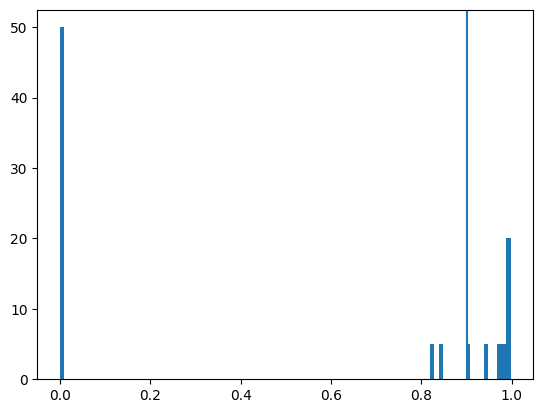

In [26]:
plt.hist((network.selectivity_mtl_sparse.max(axis=1)[0]).flatten(), bins=100)
plt.axvline(0.9)

(array([50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,
         0.,  5.,  0.,  0.,  5., 10.,  5., 10., 10.]),
 array([0.        , 0.00993371, 0.01986742, 0.02980113, 0.03973484,
        0.04966855, 0.05960226, 0.06953596, 0.07946967, 0.08940338,
        0.09933709, 0.1092708 , 0.11920451, 0.12913822, 0.13907193,
        0.14900564, 0.15893935, 0.16887306, 0.17880677, 0.18874048,
        0.19867419, 0.2086079 , 0.21854161, 0.22847532, 0.23840903,
        0.24834274, 0.25827643, 0.26821014, 0.27814385, 0.28807756,
        0.29801127, 0.3079

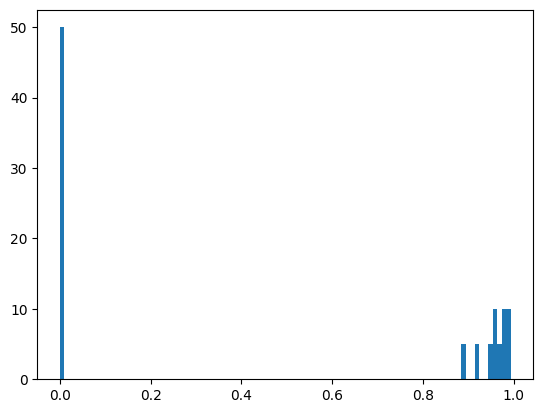

In [71]:
plt.hist((network.selectivity_mtl_sparse.max(axis=1)[0]).flatten(), bins=100)

In [94]:
import types

def mtl_generate(self, semantic_charge, num_iterations=None):
    num_iterations = num_iterations  if num_iterations != None else getattr(self, 'mtl_generate_pattern_complete_iterations')
    #mtl_sparse_sparsity = (semantic_charge/self.max_semantic_charge_input)*self.mtl_sparse_sparsity.clone()
    #h_random_sparse = torch.randn(self.mtl_sparse_size)
    #h_sparse = self.pattern_complete('mtl_sparse', h_0=h_random_sparse, num_iterations=num_iterations, sparsity=mtl_sparse_sparsity)
    mtl_sparsity = (semantic_charge/self.max_semantic_charge_input)*self.mtl_sparsity.clone()
    #h_conditioned = torch.zeros(self.mtl_size)
    #h_conditioned[self.mtl_dense_size:] = h_sparse
    h_random = torch.randn(self.mtl_size)**2
    #h_random[self.mtl_dense_size:] = h_sparse
    h = self.pattern_complete('mtl', h_0=h_random, h_conditioned=None, num_iterations=num_iterations, sparsity=mtl_sparsity)
    return h



# Bind it to *this* instance
network.mtl_generate = types.MethodType(mtl_generate, network)

In [6]:

network_parameters["mtl_mtl_lmbda"] = 5e-3
network_parameters["max_pre_mtl_mtl"] = np.inf
network_parameters["max_post_mtl_mtl"] = np.inf

network_parameters["mtl_dense_mtl_dense_lmbda"] = 5e-3
network_parameters["max_pre_mtl_dense_mtl_dense"] = np.inf
network_parameters["max_post_mtl_dense_mtl_dense"] = np.inf

network_parameters["mtl_sparse_mtl_sparse_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_mtl_sparse"] = np.inf
network_parameters["max_post_mtl_sparse_mtl_sparse"] = np.inf



network.mtl_mtl_lmbda = network_parameters["mtl_mtl_lmbda"]
network.mtl_dense_mtl_dense_lmbda = network_parameters["mtl_dense_mtl_dense_lmbda"]
network.mtl_sparse_mtl_sparse_lmbda = network_parameters["mtl_sparse_mtl_sparse_lmbda"]

network.max_pre_mtl_mtl = network_parameters["max_pre_mtl_mtl"]
network.max_post_mtl_mtl = network_parameters["max_post_mtl_mtl"]
network.max_pre_mtl_dense_mtl_dense = network_parameters["max_pre_mtl_dense_mtl_dense"]
network.max_post_mtl_dense_mtl_dense = network_parameters["max_post_mtl_dense_mtl_dense"]
network.max_pre_mtl_sparse_mtl_sparse = network_parameters["max_pre_mtl_sparse_mtl_sparse"]
network.max_post_mtl_sparse_mtl_sparse = network_parameters["max_post_mtl_sparse_mtl_sparse"]


In [13]:
network.ctx_b[100:] = 0.6
network.max_semantic_charge_replay = 1
network.max_semantic_charge_input = 2

In [8]:
#recording_parameters["connections"] = ["mtl_sparse_ctx"]

network.init_recordings(recording_parameters)
network.frozen = False
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf


input_params["num_days"] = 10
input_params["day_length"] = 200
input_params["mean_duration"] = 1

latent_specs["prob_list"] = [0.2 if i==0 else 0 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

for k in range(1, 5):
    latent_specs["prob_list"] = [0.2 if i==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

for k in range(5):
    latent_specs["prob_list"] = [0.2 if j==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0
0
0
0
0
0
0
0
0
0


In [7]:
#recording_parameters["connections"] = ["mtl_sparse_ctx"]

network.init_recordings(recording_parameters)
network.frozen = False
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf



input_params["num_days"] = 100
input_params["day_length"] = 80
input_params["mean_duration"] = 5
#latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]

input_params["latent_space"] = LatentSpace(**latent_specs)

input, input_episodes, input_latents, network = test_network(network, input_params, sleep=True, print_rate=50)

0
50


In [8]:
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

X_episodes = F.one_hot(input_episodes[-100:].long(), num_classes=np.prod(latent_specs["dims"]))


network.selectivity_ctx, network.ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)
network.selectivity_mtl_sparse, network.ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, assembly_size=5)
network.selectivity_mtl_dense, network.ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, assembly_size=10)


network.selectivity_ctx_episodes, network.ordered_indices_ctx_episodes = get_ordered_indices(X_ctx, X_episodes, assembly_size=10)

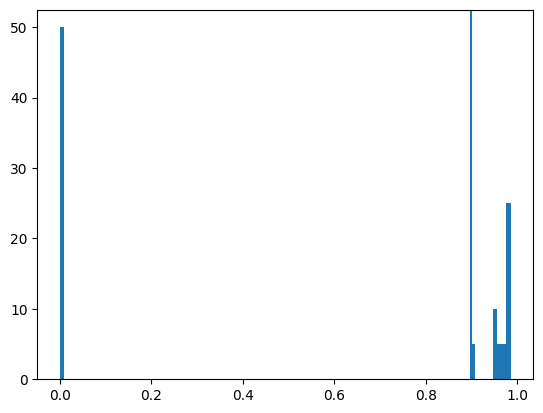

In [7]:
plt.hist((network.selectivity_mtl_sparse.max(axis=1)[0]).flatten(), bins=100)
plt.axvline(0.9)

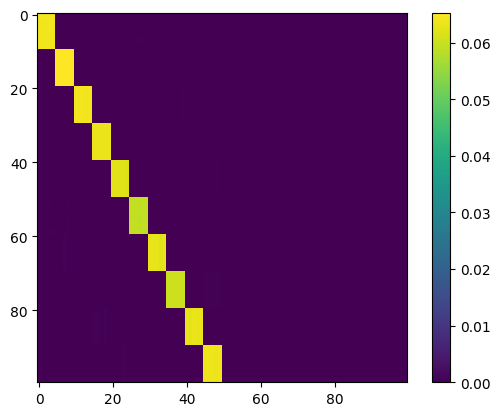

In [13]:
plt.imshow(network.ctx_mtl[network.ordered_indices_ctx[:100]][:, 100:][:, network.ordered_indices_mtl_sparse])
plt.colorbar()

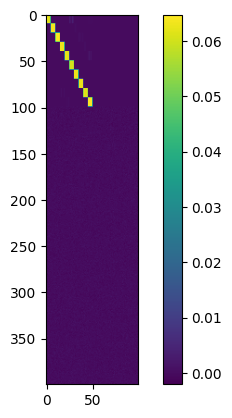

In [156]:
plt.imshow(network.ctx_mtl[network.ordered_indices_ctx][:, 100:][:, network.ordered_indices_mtl_sparse])
plt.colorbar()

In [14]:
#torch.save(network, "checkpoints/network_7_pre.pt")
network = torch.load("checkpoints/network_7_pre.pt", weights_only=False)

In [18]:
network_plastic = deepcopy(network)

(array([ 1.,  3.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,
         0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  5.,  3., 10.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,
         0., 10.,  0.,  0.,  0.,  0.,  0.,  0., 10.]),
 array([0.9366613 , 0.9372164 , 0.93777144, 0.93832654, 0.93888158,
        0.93943667, 0.93999177, 0.94054681, 0.94110191, 0.94165701,
        0.94221205, 0.94276714, 0.94332218, 0.94387728, 0.94443238,
        0.94498742, 0.94554251, 0.94609761, 0.94665265, 0.94720775,
        0.94776279, 0.94831789, 0.94887298, 0.94942802, 0.94998312,
        0.95053816, 0.95109326, 0.95164835, 0.95220339, 0.95275849,
        0.95331359, 0.9538

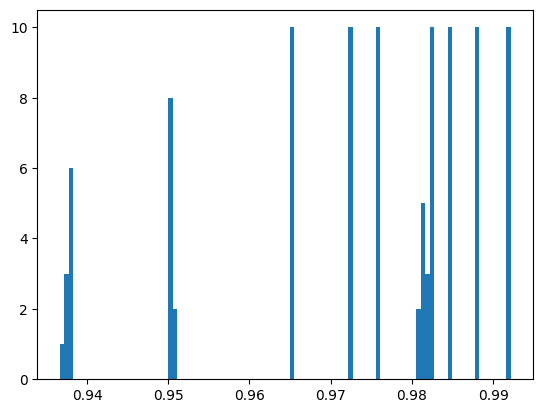

In [16]:
plt.hist(network.selectivity_ctx[network.ordered_indices_ctx[:100]].max(axis=1)[0].flatten(), bins=100)

In [15]:
plt.hist(selectivity_ctx[network.ordered_indices_ctx[:100]].max(axis=1)[0].flatten(), bins=100)

NameError: name 'selectivity_ctx' is not defined

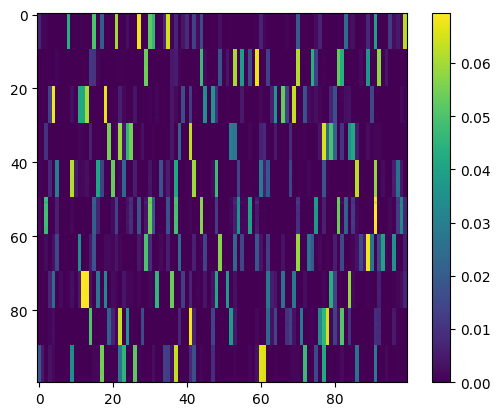

In [17]:
plt.imshow(network.ctx_mtl[network.ordered_indices_ctx[:100]][:, :100])
plt.colorbar()

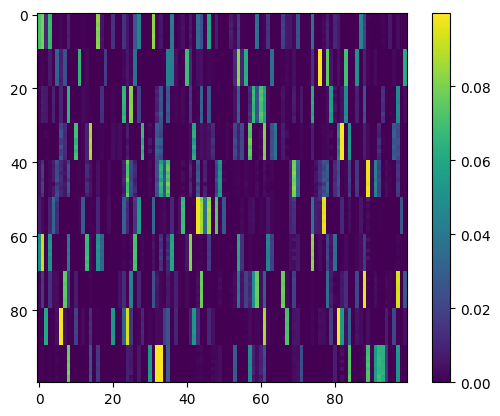

In [8]:
plt.imshow(network.ctx_mtl[network.ordered_indices_ctx[:100]][:, :100])
plt.colorbar()

In [229]:
ctx_mtl_post = network.ctx_mtl[network.ordered_indices_ctx[:100]][:, :100].clone()


In [25]:
ctx_mtl_post = network.ctx_mtl[network.ordered_indices_ctx[:100]][:, :100].clone()
ctx_mtl_pre = network_frozen.ctx_mtl[network.ordered_indices_ctx[:100]][:, :100].clone()

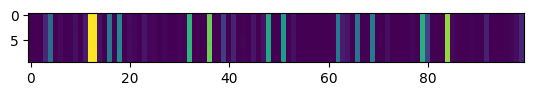

In [57]:
plt.imshow(ctx_mtl_pre[70:80])

In [60]:
get_cos_sim_torch(ctx_mtl_post[70:80, :].flatten(), ctx_mtl_pre[70:80, :].flatten())

tensor(0.8687)

In [26]:
for i in range(10):
    print(get_cos_sim_torch(ctx_mtl_post[i*10:10*(i+1), :].flatten(), ctx_mtl_pre[i*10:10*(i+1), :].flatten()))

tensor(0.9668)
tensor(0.9573)
tensor(0.9802)
tensor(0.9739)
tensor(0.9810)
tensor(0.9796)
tensor(0.9452)
tensor(0.9765)
tensor(0.9820)
tensor(0.9752)


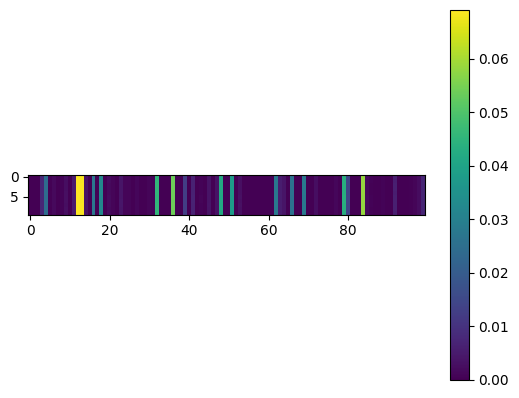

In [52]:
plt.imshow(network.ctx_mtl[network.ordered_indices_ctx[70:80]][:, :100])
plt.colorbar()

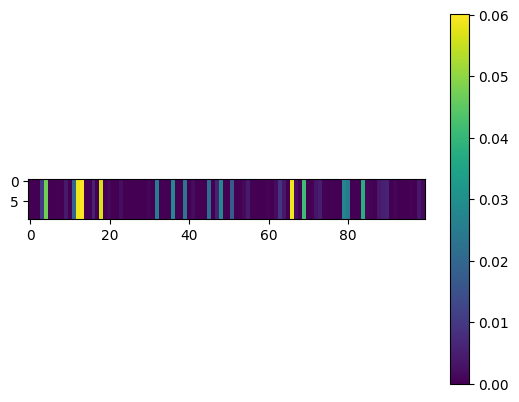

In [53]:
plt.imshow(network_plastic.ctx_mtl[network.ordered_indices_ctx[70:80]][:, :100])
plt.colorbar()

In [54]:
get_cos_sim_torch(network_plastic.ctx_mtl[network.ordered_indices_ctx[70:80]][:, :100].flatten(), network.ctx_mtl[network.ordered_indices_ctx[70:80]][:, :100].flatten())

tensor(0.8687)

In [32]:
network.day

1600

In [39]:
network.max_semantic_charge_replay = 1
network.init_recordings(recording_parameters)
network.frozen = False
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

network_frozen.max_semantic_charge_replay = 1
network_frozen.init_recordings(recording_parameters)
network_frozen.frozen = True
network_frozen.activity_recordings_rate = 1
network_frozen.connectivity_recordings_rate = np.inf



input_params["num_days"] = 500
input_params["day_length"] = 80
input_params["mean_duration"] = 5
#latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]

input_params["latent_space"] = LatentSpace(**latent_specs)



input, input_episodes, input_latents = make_input(**input_params)


sleep = True
print_rate = 50
with torch.no_grad():
    for day in range(input_params["num_days"]):
        if day%print_rate == 0:
            print(day)
        network(input[day], debug=False)
        network_frozen(input[day], debug=False)
        if sleep:
            network.sleep()
            network_frozen.sleep()


0
50
100
150
200
250
300
350
400
450


In [40]:
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

X_episodes = F.one_hot(input_episodes[-100:].long(), num_classes=np.prod(latent_specs["dims"]))


network.selectivity_ctx, network.ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)
network.selectivity_mtl_sparse, network.ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, assembly_size=5)
network.selectivity_mtl_dense, network.ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, assembly_size=10)
network.selectivity_ctx_episodes, network.ordered_indices_ctx_episodes = get_ordered_indices(X_ctx, X_episodes, assembly_size=10)

In [23]:
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

X_episodes = F.one_hot(input_episodes[-100:].long(), num_classes=np.prod(latent_specs["dims"]))


selectivity_ctx, ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)

In [26]:
X_ctx = torch.stack(network_plastic.activity_recordings["ctx"], dim=0)[network_plastic.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network_plastic.activity_recordings["mtl_sparse"], dim=0)[network_plastic.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network_plastic.activity_recordings["mtl_dense"], dim=0)[network_plastic.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

X_episodes = F.one_hot(input_episodes[-100:].long(), num_classes=np.prod(latent_specs["dims"]))


selectivity_ctx, ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)

In [27]:
selectivity_ctx[network.ordered_indices_ctx].max(axis=1)[:100][0][:100]

tensor([0.9984, 0.9984, 0.9984, 0.9984, 0.9984, 0.9984, 0.9984, 0.9984, 0.9984,
        0.9984, 0.9963, 0.9963, 0.9963, 0.9963, 0.9963, 0.9963, 0.9963, 0.9963,
        0.9963, 0.9963, 0.9960, 0.9956, 0.9964, 0.9964, 0.9956, 0.9960, 0.9964,
        0.9960, 0.9956, 0.9964, 0.9937, 0.9937, 0.9937, 0.9937, 0.9937, 0.9937,
        0.9937, 0.9937, 0.9937, 0.9937, 0.9972, 0.9976, 0.9972, 0.9976, 0.9976,
        0.9976, 0.9976, 0.9982, 0.9982, 0.9972, 0.7347, 0.7347, 0.7347, 0.7347,
        0.7347, 0.7347, 0.7347, 0.7347, 0.7347, 0.7347, 0.9846, 0.9846, 0.9846,
        0.9846, 0.9846, 0.9846, 0.9846, 0.9846, 0.9846, 0.9846, 0.7886, 0.7886,
        0.7886, 0.7886, 0.7886, 0.7886, 0.7886, 0.7886, 0.7886, 0.7886, 0.8463,
        0.8463, 0.8463, 0.8463, 0.8463, 0.8463, 0.8463, 0.8463, 0.8463, 0.8463,
        0.8697, 0.8697, 0.8697, 0.8697, 0.8697, 0.8697, 0.8697, 0.8697, 0.8697,
        0.8697])

In [51]:
network.selectivity_mtl_sparse[network.ordered_indices_mtl_sparse[:50]].max(axis=1)

torch.return_types.max(
values=tensor([0.9437, 0.9437, 0.9437, 0.9437, 0.9437, 0.9683, 0.9683, 0.9683, 0.9683,
        0.9683, 0.9594, 0.9594, 0.9594, 0.9594, 0.9594, 0.8548, 0.8548, 0.8548,
        0.8548, 0.8548, 0.9436, 0.9436, 0.9436, 0.9436, 0.9436, 0.8776, 0.8776,
        0.8776, 0.8776, 0.8776, 0.9499, 0.9499, 0.9499, 0.9499, 0.9499, 0.9599,
        0.9599, 0.9599, 0.9599, 0.9599, 0.9289, 0.9289, 0.9289, 0.9289, 0.9289,
        0.9585, 0.9585, 0.9585, 0.9585, 0.9585]),
indices=tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9]))

In [203]:
network.selectivity_mtl_sparse[network.ordered_indices_mtl_sparse[:50]].max(axis=1)

torch.return_types.max(
values=tensor([0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9479, 0.9479, 0.9479, 0.9479,
        0.9479, 0.9491, 0.9491, 0.9491, 0.9491, 0.9491, 0.8727, 0.8727, 0.8727,
        0.8727, 0.8727, 0.8620, 0.8620, 0.8620, 0.8620, 0.8620, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.7087, 0.8137, 0.8137, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.7742, 0.7742, 0.7742, 0.7742, 0.7742,
        0.8835, 0.8835, 0.8835, 0.8835, 0.8835]),
indices=tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9]))

In [28]:
plt.hist((selectivity_ctx.max(axis=1)[0]).flatten(), bins=100)

NameError: name 'selectivity_ctx' is not defined

In [30]:
(network.selectivity_mtl_sparse.max(axis=1)[0])

tensor([0.9716, 0.9441, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9566, 0.8635,
        0.9709, 0.9709, 0.0000, 0.9630, 0.9910, 0.0000, 0.0000, 0.8635, 0.9910,
        0.0000, 0.0000, 0.9716, 0.9543, 0.0000, 0.9566, 0.9441, 0.9630, 0.0000,
        0.0000, 0.0000, 0.9709, 0.9688, 0.0000, 0.9581, 0.9441, 0.0000, 0.9441,
        0.9441, 0.0000, 0.9688, 0.9716, 0.9709, 0.0000, 0.0000, 0.9910, 0.9566,
        0.0000, 0.9543, 0.0000, 0.0000, 0.9716, 0.0000, 0.9910, 0.8635, 0.9566,
        0.9630, 0.9688, 0.9566, 0.9581, 0.0000, 0.9581, 0.0000, 0.0000, 0.9543,
        0.9630, 0.9709, 0.0000, 0.9688, 0.9688, 0.0000, 0.9543, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9910, 0.0000, 0.0000,
        0.9716, 0.0000, 0.0000, 0.9581, 0.0000, 0.9543, 0.0000, 0.0000, 0.0000,
        0.8635, 0.0000, 0.8635, 0.0000, 0.9630, 0.9581, 0.0000, 0.0000, 0.0000,
        0.0000])

(array([50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  5., 15., 15.,  5.,  5.]),
 array([0.        , 0.00990962, 0.01981923, 0.02972885, 0.03963847,
        0.04954808, 0.0594577 , 0.06936732, 0.07927693, 0.08918655,
        0.09909616, 0.10900579, 0.1189154 , 0.12882502, 0.13873464,
        0.14864425, 0.15855387, 0.16846348, 0.1783731 , 0.18828271,
        0.19819233, 0.20810196, 0.21801157, 0.22792119, 0.2378308 ,
        0.24774042, 0.25765005, 0.26755965, 0.27746928, 0.28737888,
        0.29728851, 0.3071

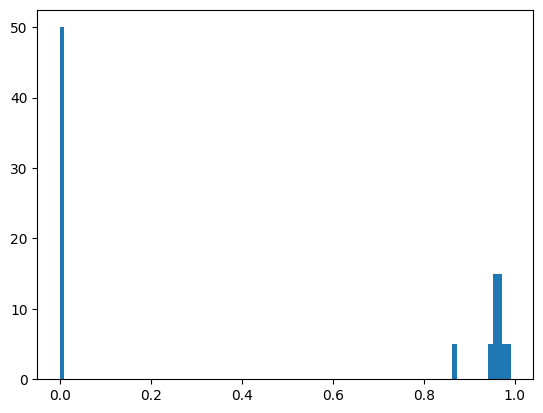

In [34]:
plt.hist((network.selectivity_mtl_sparse.max(axis=1)[0]).flatten(), bins=100)

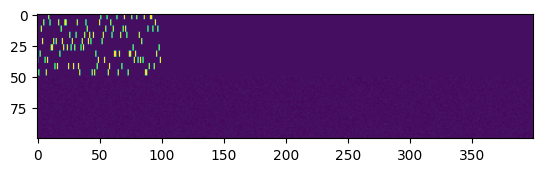

In [15]:
plt.imshow(network.mtl_sparse_ctx[network.ordered_indices_mtl_sparse])

(array([50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., 10.,  0., 20., 20.]),
 array([0.        , 0.00762377, 0.01524754, 0.0228713 , 0.03049507,
        0.03811884, 0.04574261, 0.05336637, 0.06099014, 0.06861391,
        0.07623768, 0.08386145, 0.09148522, 0.09910898, 0.10673275,
        0.11435652, 0.12198029, 0.12960406, 0.13722782, 0.1448516 ,
        0.15247536, 0.16009912, 0.1677229 , 0.17534666, 0.18297043,
        0.1905942 , 0.19821796, 0.20584174, 0.2134655 , 0.22108927,
        0.22871304, 0.2363

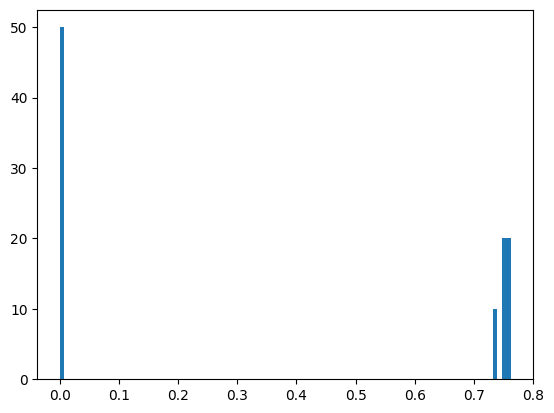

In [44]:
plt.hist((network.selectivity_mtl_sparse.max(axis=1)[0]).flatten(), bins=100)

In [31]:
network.selectivity_ctx_episodes[network.ordered_indices_ctx[:250]].max(axis=1)

torch.return_types.max(
values=tensor([0.4416, 0.4393, 0.4418, 0.4418, 0.4406, 0.4406, 0.4392, 0.4392, 0.4402,
        0.4392, 0.4315, 0.4313, 0.4315, 0.4313, 0.4312, 0.4315, 0.4312, 0.4313,
        0.4313, 0.4313, 0.4293, 0.4293, 0.4293, 0.4293, 0.4293, 0.4293, 0.4292,
        0.4293, 0.4293, 0.4293, 0.4285, 0.4285, 0.4287, 0.4287, 0.4285, 0.4287,
        0.4287, 0.4287, 0.4287, 0.4287, 0.4696, 0.4696, 0.4694, 0.4696, 0.4696,
        0.4696, 0.4694, 0.4696, 0.4696, 0.4696, 0.4535, 0.4537, 0.4535, 0.4535,
        0.4537, 0.4535, 0.4537, 0.4535, 0.4535, 0.4537, 0.4767, 0.4771, 0.4769,
        0.4769, 0.4769, 0.4771, 0.4771, 0.4769, 0.4771, 0.4769, 0.3971, 0.3971,
        0.3972, 0.3971, 0.3971, 0.3971, 0.3972, 0.3971, 0.3972, 0.3971, 0.4295,
        0.4294, 0.4295, 0.4295, 0.4295, 0.4295, 0.4295, 0.4295, 0.4295, 0.4295,
        0.4349, 0.4349, 0.4350, 0.4349, 0.4349, 0.4349, 0.4349, 0.4349, 0.4349,
        0.4349, 0.9982, 0.9829, 0.9929, 0.9929, 0.1109, 0.0000, 0.1292, 0.9862,
        0

(array([18.,  7., 18., 21., 20., 37., 81., 48., 61., 89.]),
 array([0.05624072, 0.14835615, 0.2404716 , 0.33258706, 0.4247025 ,
        0.51681793, 0.60893339, 0.70104885, 0.79316431, 0.88527972,
        0.97739518]),
 <BarContainer object of 10 artists>)

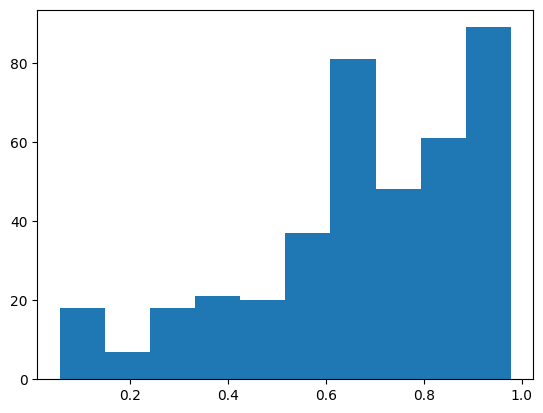

In [107]:
plt.hist((network.selectivity_ctx_episodes.max(axis=1)[0]).flatten())

In [42]:
#torch.save(network, "checkpoints/network_7_random.pt")
#network = torch.load("checkpoints/network_7_random.pt", weights_only=False)

In [47]:
mtl = torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A]
ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A]

In [160]:
mtl = torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A]
ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A]

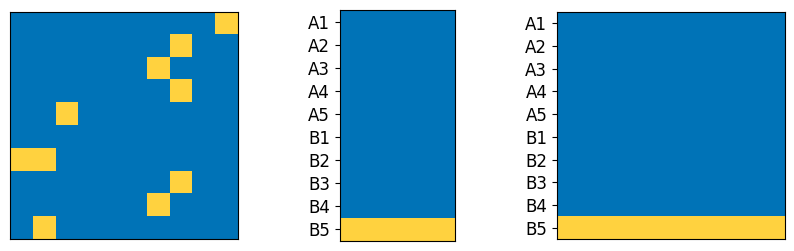

In [170]:




index = 9


mtl = torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A]
ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A]

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(mtl[index, :100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl[index, 100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx[index, network.ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]

ax[2].set_yticks(positions, labels, fontsize=12)

In [26]:
mtl = torch.stack(network.activity_recordings["mtl"], dim=0)[network.awake_indices]
ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices]

In [27]:
mtl_plastic = torch.stack(network_plastic.activity_recordings["mtl"], dim=0)[network_plastic.awake_indices]
ctx_plastic = torch.stack(network_plastic.activity_recordings["ctx"], dim=0)[network_plastic.awake_indices]

In [42]:
ctx_hat = F.linear(mtl[:, :100], network.ctx_mtl[:, :100])
ctx_hat_plastic = F.linear(mtl_plastic[:, :100], network_plastic.ctx_mtl[:, :100])

In [321]:
index = -7

In [331]:
ctx_hat[index, network.ordered_indices_ctx][:100].shape

torch.Size([100])

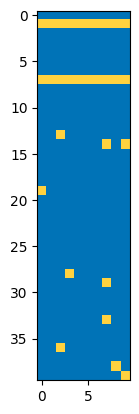

In [43]:
plt.imshow(network.activation(ctx_hat[index, network.ordered_indices_ctx], 'ctx')[0].reshape((-1, 10)), cmap=blue_yellow)

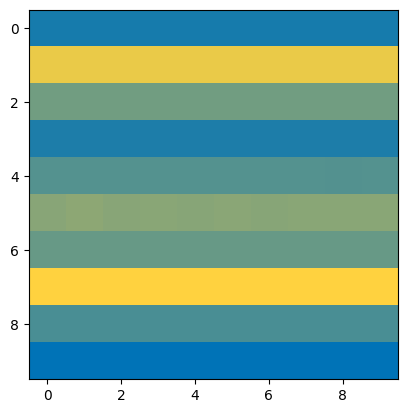

In [44]:
plt.imshow(ctx_hat[index, network.ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)

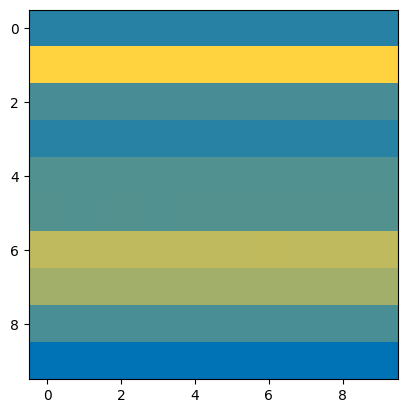

In [45]:
plt.imshow(ctx_hat_plastic[index, network.ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)

In [276]:
index = -2

In [278]:
index = -3

In [256]:
plt.imshow(ctx_pre[index, network.ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)

torch.Size([40000, 2])

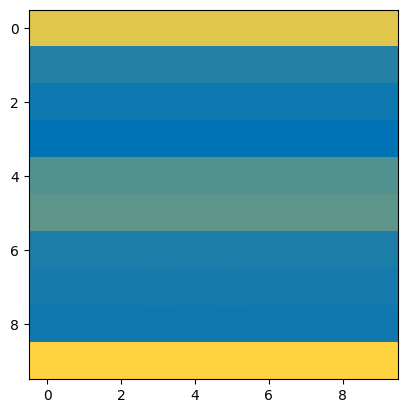

In [279]:
plt.imshow(ctx_pre[index, network.ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)

In [288]:
input_latents.flatten(end_dim=1).shape

torch.Size([40000, 2])

tensor([1, 2], dtype=torch.int32)


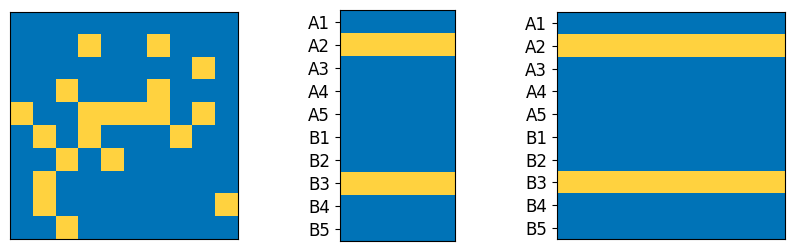

In [33]:
index = -7

print(input_latents.flatten(end_dim=1)[index])


fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(mtl[index, :100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl[index, 100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx[index, network.ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]

ax[2].set_yticks(positions, labels, fontsize=12)

tensor([1, 2], dtype=torch.int32)


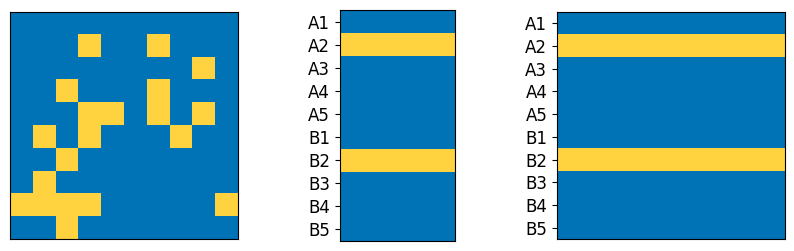

In [34]:
index = -7

print(input_latents.flatten(end_dim=1)[index])


fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(mtl_plastic[index, :100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl_plastic[index, 100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx_plastic[index, network.ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]

ax[2].set_yticks(positions, labels, fontsize=12)

In [15]:
torch.save(network, "checkpoints/network_7_random.pt")
network = torch.load("checkpoints/network_7_random.pt", weights_only=False)

In [16]:
network.init_recordings(recording_parameters)
network.frozen = False
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = 1

input_params["num_days"] = 1
latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

input, input_episodes, input_latents, network = test_network(network, input_params, sleep=True, print_rate=50)

0


In [17]:
h_random = torch.randn(network.mtl_size)
mtl = h_random


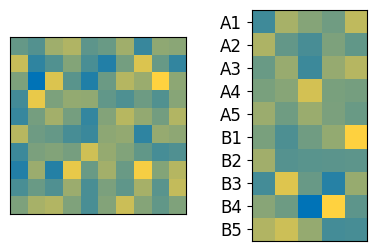

In [18]:
mtl = h_random



fig, ax = plt.subplots(1, 2, figsize=(5, 3))
ax[0].imshow(mtl[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(mtl[100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]
ax[1].set_yticks(positions, labels, fontsize=12)

plt.savefig('Figures_SVG/7b1.svg', dpi=300, transparent=True)

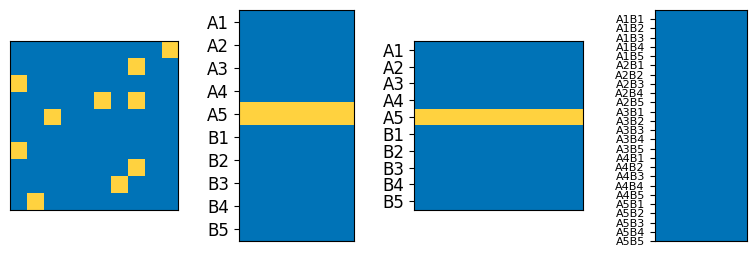

In [19]:
semantic_charge = 1
mtl_sparsity = (semantic_charge/network.max_semantic_charge_input)*network.mtl_sparsity.clone()
mtl = network.pattern_complete('mtl', h_0=h_random, sparsity=mtl_sparsity)


ctx_hat = F.linear(mtl, network.ctx_mtl) + network.ctx_b*network.ctx_IM
ctx, _ = network.activation(ctx_hat, 'ctx', sleep=True, subregion_index=0)



fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].imshow(mtl[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl[100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx[network.ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)
ax[3].imshow(ctx[network.ordered_indices_ctx][100:350].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]

ax[2].set_yticks(positions, labels, fontsize=12)




# Example parameters
N = 25  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [M * (k + 0.5) for k in range(NA * NB)]


ax[3].set_yticks(positions_episodes, labels_episodes, fontsize=8)

plt.savefig('Figures_SVG/7b2.svg', dpi=300, transparent=True)

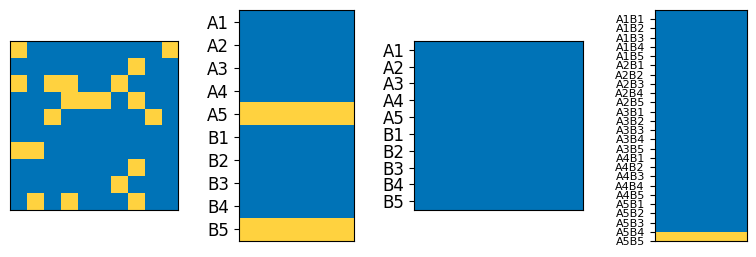

In [20]:
semantic_charge = 2
mtl_sparsity = (semantic_charge/network.max_semantic_charge_input)*network.mtl_sparsity.clone()
mtl = network.pattern_complete('mtl', h_0=h_random, sparsity=mtl_sparsity)


ctx_hat = F.linear(mtl, network.ctx_mtl) + network.ctx_b*network.ctx_IM
ctx, _ = network.activation(ctx_hat, 'ctx', sleep=True, subregion_index=1)



fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].imshow(mtl[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl[100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[3].imshow(ctx[network.ordered_indices_ctx_episodes][:250].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]

ax[2].set_yticks(positions, labels, fontsize=12)

# Example parameters
N = 25  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [M * (k + 0.5) for k in range(NA * NB)]


ax[3].set_yticks(positions_episodes, labels_episodes, fontsize=8)


plt.savefig('Figures_SVG/7b3.svg', dpi=300, transparent=True)

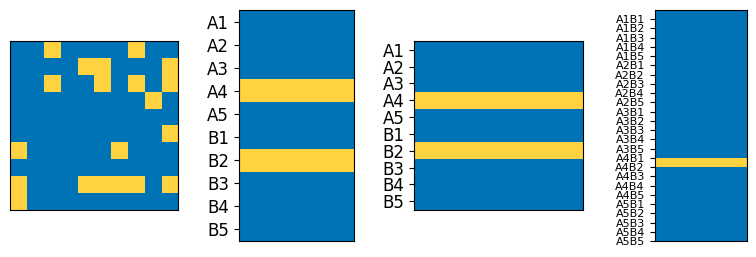

In [21]:
mtl = torch.stack(network.activity_recordings["mtl"], axis=0)[network.awake_indices][-1]
ctx = torch.stack(network.activity_recordings["ctx"], axis=0)[network.awake_indices][-1]


fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].imshow(mtl[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl[100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx[network.ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)
ax[3].imshow(ctx[network.ordered_indices_ctx_episodes][:250].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]

ax[2].set_yticks(positions, labels, fontsize=12)

# Example parameters
N = 25  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [M * (k + 0.5) for k in range(NA * NB)]


ax[3].set_yticks(positions_episodes, labels_episodes, fontsize=8)


plt.savefig('Figures_SVG/7c.svg', dpi=300, transparent=True)

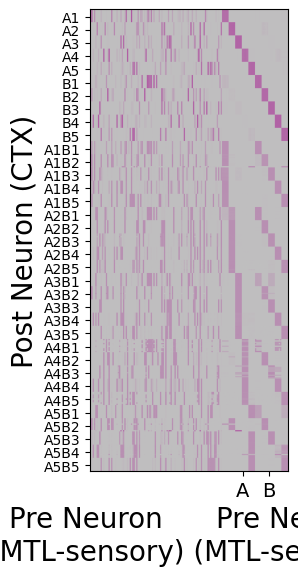

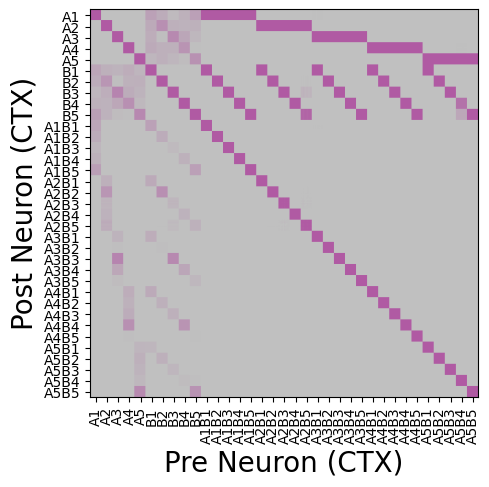

In [12]:

fig = plt.figure(figsize=(5, 6))


plt.imshow(network.ctx_ctx[full_ordered_indices_ctx][:, full_ordered_indices_ctx], cmap=gray_purple)


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]


# Example parameters
N = 250  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [100 + M * (k + 0.5) for k in range(NA * NB)]

positions.extend(positions_episodes)
labels.extend(labels_episodes)

plt.yticks(positions, labels)
plt.xticks(positions, labels, rotation=90)


plt.xlabel("Pre Neuron (CTX)", fontsize=20)
plt.ylabel("Post Neuron (CTX)", fontsize=20)

plt.savefig('Figures_SVG/7e.svg', dpi=300, transparent=True)


In [57]:
network = torch.load("checkpoints/network_7_random.pt", weights_only=False)
network.ctx_b[100:] = 0.6

In [58]:
recording_parameters["connections"] = ["mtl_sparse_ctx"]

network.init_recordings(recording_parameters)
network.frozen = False
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf



input_params["num_days"] = 1000
input_params["day_length"] = 5
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]

input_params["latent_space"] = LatentSpace(**latent_specs)

input, input_episodes, input_latents, network = test_network(network, input_params, sleep=True, print_rate=50)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [55]:
def get_selectivity(recordings, latents):
    # Flatten time
    _, num_neurons = recordings.shape


    days, day_length, num_latents = latents.shape

    recordings_flat = recordings.reshape(-1, num_neurons).float()    # shape: (days * day_length, num_neurons)
    latents_flat = latents.reshape(-1, num_latents).float()    # shape: (days * day_length, num_latents)


    # Normalize (zero mean, unit variance)
    latents_norm = (latents_flat - latents_flat.mean(dim=0)) / latents_flat.std(dim=0)
    recordings_norm = (recordings_flat - recordings_flat.mean(dim=0)) / recordings_flat.std(dim=0)


    # Compute correlation (selectivity): (num_neurons, num_latents)
    selectivity = recordings_norm.T @ latents_norm / latents_norm.shape[0]


    return selectivity



def get_ordered_indices(recordings, latents, assembly_size = 10, threshold=0.9):
    selectivity = get_selectivity(recordings, latents)
    num_neurons, num_latents = selectivity.shape

    # Identify the latent with the highest selectivity per neuron
    max_selectivity, max_latent_idx = selectivity.max(dim=1)

    

    # Generate reordered indices
    ordered_indices = []

    # Iterate over each latent to collect selective neurons
    for latent in range(num_latents):
        # Step 1: Get the mask for elements where max_latent_idx == latent
        mask = (max_latent_idx == latent)

        # Step 2: Get the indices of the masked elements (relative to original tensor)
        original_indices = mask.nonzero(as_tuple=False).squeeze()

        # Step 3: Select the values of max_selectivity at those positions
        filtered_values = max_selectivity[mask]

        # Step 4: Get the topk indices within the filtered values
        topk_within_filtered = torch.topk(filtered_values, assembly_size).indices

        # Step 5: Map back to original indices
        latent_neurons = original_indices[topk_within_filtered]


        ordered_indices.append(latent_neurons)


    return selectivity, torch.concatenate(ordered_indices, axis=0)

In [57]:
#X_sen = torch.stack(network.activity_recordings["sen"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

X_episodes = F.one_hot(input_episodes[-100:].long(), num_classes=np.prod(latent_specs["dims"]))


network.selectivity_ctx, network.ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, threshold=0.7)
network.selectivity_mtl_sparse, network.ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, threshold=0.7, assembly_size=5)
#network.selectivity_mtl_dense, network.ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, threshold=0.7)


network.selectivity_ctx_episodes, network.ordered_indices_ctx_episodes = get_ordered_indices(X_ctx, X_episodes, threshold=0.5)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (400x621 and 8000x10)

In [34]:
h_random = torch.randn(network.mtl_size)
mtl = h_random

(array([ 5.,  0.,  5.,  0.,  5., 10.,  5.,  5., 10.,  5.]),
 array([0.8461538 , 0.86133873, 0.87652367, 0.89170867, 0.90689361,
        0.92207855, 0.93726349, 0.95244843, 0.96763343, 0.98281837,
        0.9980033 ]),
 <BarContainer object of 10 artists>)

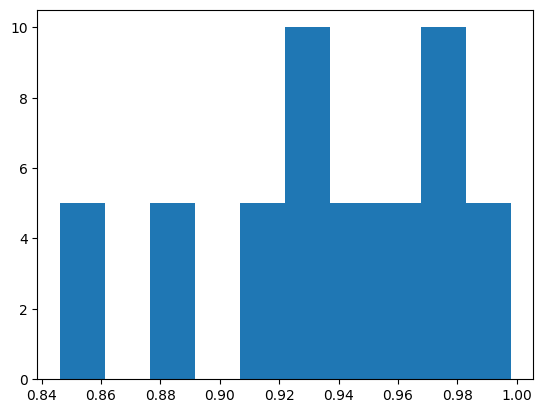

In [42]:
plt.hist(network.selectivity_mtl_sparse.max(axis=1)[0])

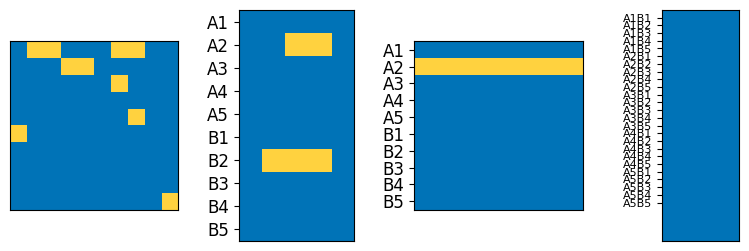

In [50]:
semantic_charge = 1
mtl_sparsity = (semantic_charge/network.max_semantic_charge_input)*network.mtl_sparsity.clone()
mtl = network.pattern_complete('mtl', h_0=h_random, sparsity=mtl_sparsity)


ctx_hat = F.linear(mtl, network.ctx_mtl) + network.ctx_b*network.ctx_IM
ctx, _ = network.activation(ctx_hat, 'ctx', sleep=True, subregion_index=0)



fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].imshow(mtl[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl[100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx[network.ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)
ax[3].imshow(ctx[100:].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]

ax[2].set_yticks(positions, labels, fontsize=12)




# Example parameters
N = 25  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [M * (k + 0.5) for k in range(NA * NB)]


ax[3].set_yticks(positions_episodes, labels_episodes, fontsize=8)

plt.savefig('Figures_SVG/7b2.svg', dpi=300, transparent=True)

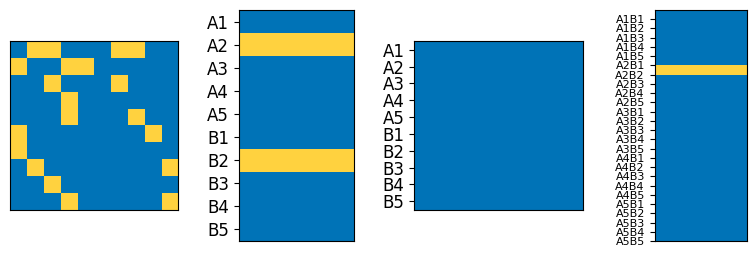

In [45]:
semantic_charge = 2
mtl_sparsity = (semantic_charge/network.max_semantic_charge_input)*network.mtl_sparsity.clone()
mtl = network.pattern_complete('mtl', h_0=h_random, sparsity=mtl_sparsity)


ctx_hat = F.linear(mtl, network.ctx_mtl) + network.ctx_b*network.ctx_IM
ctx, _ = network.activation(ctx_hat, 'ctx', sleep=True, subregion_index=1)



fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].imshow(mtl[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl[100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[3].imshow(ctx[network.ordered_indices_ctx_episodes][:250].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]

ax[2].set_yticks(positions, labels, fontsize=12)

# Example parameters
N = 25  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [M * (k + 0.5) for k in range(NA * NB)]


ax[3].set_yticks(positions_episodes, labels_episodes, fontsize=8)


plt.savefig('Figures_SVG/7b3.svg', dpi=300, transparent=True)

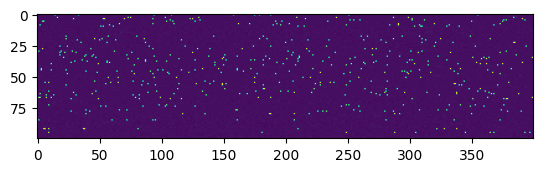

In [407]:
plt.imshow(network.mtl_sparse_ctx)

In [465]:
 s

In [464]:
def test_network(net, input_params, sleep=True, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      if sleep:
        net.sleep()
  return input, input_episodes, input_latents, net

In [ ]:
recording_parameters["connections"] = ["mtl_sparse_ctx"]

network.init_recordings(recording_parameters)
network.frozen = False
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = 1



input_params["num_days"] = 500
#latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]

input_params["latent_space"] = LatentSpace(**latent_specs)

input, input_episodes, input_latents, network = test_network(network, input_params, sleep=True, print_rate=50)

0
50
100
150
200
250
300
350
400
450


In [524]:
X_sen = torch.stack(network.activity_recordings["sen"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

X_episodes = F.one_hot(input_episodes[-100:].long(), num_classes=np.prod(latent_specs["dims"]))


network.selectivity_ctx, network.ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, threshold=0.7)
network.selectivity_mtl_sparse, network.ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, threshold=0.7)
network.selectivity_mtl_dense, network.ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, threshold=0.7)


network.selectivity_ctx_episodes, network.ordered_indices_ctx_episodes = get_ordered_indices(X_ctx, X_episodes, threshold=0.7)

In [424]:
network.selectivity_mtl_sparse.max(axis=1)

torch.return_types.max(
values=tensor([   nan, 0.5968,    nan, 0.7465, 0.3960, 0.5790, 0.3099,    nan, 0.4363,
        0.5579, 0.2651,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
        0.3340,    nan, 0.2475, 0.3594,    nan, 0.5667,    nan,    nan, 0.4934,
           nan, 0.2968,    nan, 0.4022, 0.3711,    nan, 0.2850, 0.3447, 0.5891,
        0.4646, 0.3274, 0.6987, 0.8761, 0.0592, 0.7672,    nan,    nan, 0.6641,
        0.3033, 0.1596, 0.5411, 0.1359,    nan,    nan, 0.5122,    nan,    nan,
        0.7515, 0.3331, 0.5491, 0.4255,    nan,    nan, 0.3126,    nan, 0.4528,
        0.2159, 0.3219, 0.8679,    nan, 0.3835, 0.6366,    nan,    nan,    nan,
           nan, 0.3837, 0.5161,    nan,    nan, 0.3337, 0.7271,    nan, 0.4765,
           nan,    nan,    nan,    nan, 0.6161,    nan,    nan,    nan,    nan,
           nan,    nan, 0.3661,    nan,    nan, 0.4381,    nan,    nan,    nan,
           nan]),
indices=tensor([0, 9, 0, 9, 3, 8, 4, 0, 2, 1, 6, 0, 0, 0, 0, 0, 0, 0, 6

In [529]:
sum((network.selectivity_ctx_episodes.max(axis=1)[0]).flatten() >= 0.6)

tensor(267)

(array([ 10.,   1.,  20.,  10.,  40.,  20.,  30.,  49.,  30., 171.]),
 array([0.218868  , 0.29678172, 0.37469545, 0.45260915, 0.53052288,
        0.60843658, 0.68635035, 0.76426405, 0.84217775, 0.92009151,
        0.99800521]),
 <BarContainer object of 10 artists>)

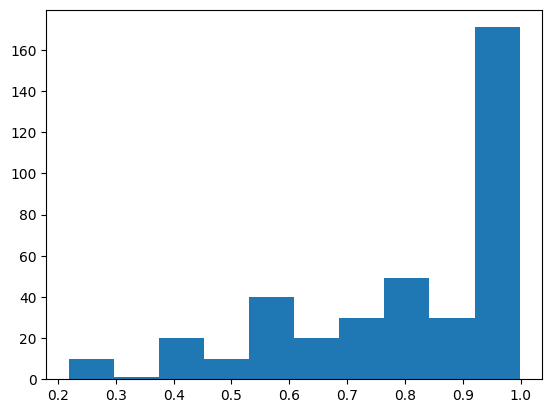

In [11]:
plt.hist((network.selectivity_ctx_episodes.max(axis=1)[0]).flatten())

In [10]:
plt.hist((network.selectivity_ctx_episodes[network.ordered_indices_ctx_episodes].max(axis=1)[0]).flatten(), bins=50)[0]

IndexError: too many indices for tensor of dimension 2

(array([ 7., 17., 65., 25.,  7., 30., 29., 33., 18., 19.]),
 array([0.50721675, 0.55525506, 0.60329336, 0.65133166, 0.69936997,
        0.74740827, 0.79544652, 0.84348482, 0.89152312, 0.93956143,
        0.98759973]),
 <BarContainer object of 10 artists>)

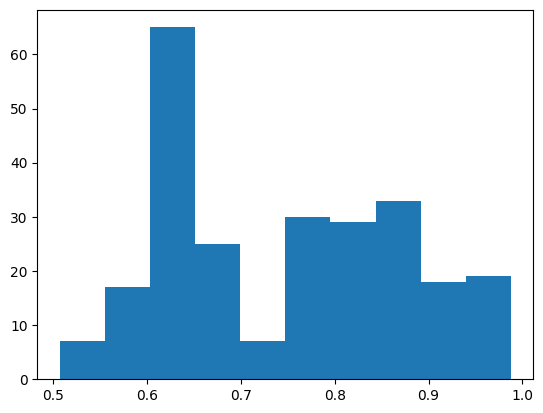

In [468]:
plt.hist((network.selectivity_ctx_episodes[network.ordered_indices_ctx_episodes[:250]].max(axis=1)[0]).flatten())

In [440]:
network.selectivity_ctx_episodes[network.ordered_indices_ctx_episodes[:250]].max(axis=1)[0].mean()

tensor(0.9675)

In [454]:
network.selectivity_ctx_episodes[network.ordered_indices_ctx_episodes[:250]].max(axis=1)[0].mean()

tensor(0.8184)

(array([53., 85., 61., 24., 17., 16., 11., 23.,  0., 10.]),
 array([0.00508081, 0.086714  , 0.16834719, 0.24998039, 0.33161357,
        0.41324678, 0.49487996, 0.57651317, 0.65814638, 0.73977953,
        0.82141274]),
 <BarContainer object of 10 artists>)

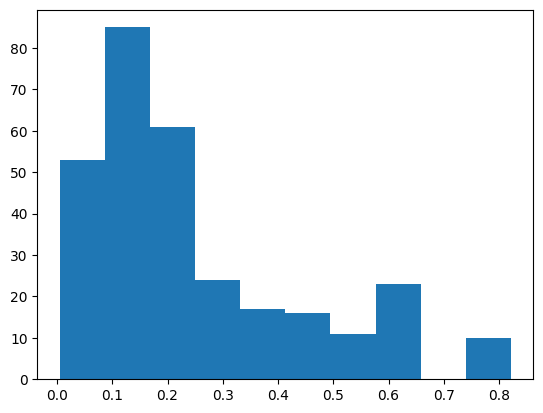

In [114]:
plt.hist(ctx_hat[100:])

In [140]:
top_indices = torch.topk(ctx_hat, 10).indices

In [141]:
top_indices

tensor([88, 64, 58, 53, 43, 16, 10, 28, 60,  2])

In [125]:
top_indices

tensor([88, 64, 58, 53, 43, 16, 10, 28, 60,  2])

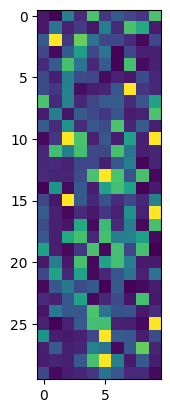

In [90]:
plt.imshow(ctx_hat[100:].reshape((-1, 10)))

In [151]:
ctx, _ = activation(network, network.ctx_hat, 'ctx', sleep=True, subregion_index=1)

10
torch.return_types.sort(
values=tensor([  4,  17,  23,  70, 136, 175, 179, 183, 194, 244]),
indices=tensor([3, 5, 1, 4, 6, 7, 9, 8, 0, 2]))


10
torch.return_types.sort(
values=tensor([ 21,  67, 102, 109, 135, 152, 169, 259, 265, 285]),
indices=tensor([3, 6, 4, 1, 5, 8, 9, 0, 2, 7]))


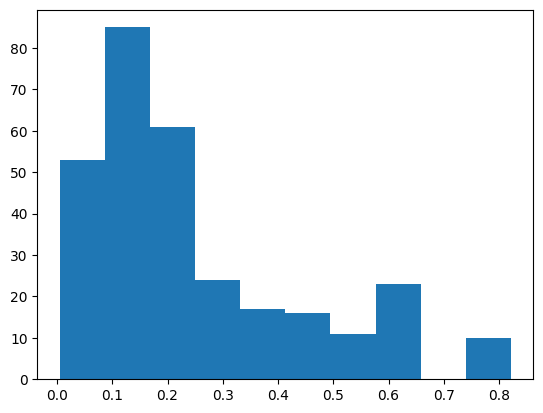

In [ ]:
ctx, _ = activation(network, ctx_hat, 'ctx', sleep=True, subregion_index=1)

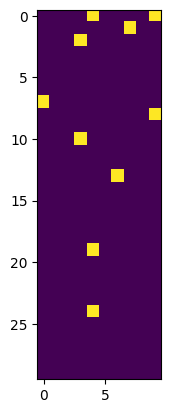

In [111]:
plt.imshow(ctx[100:].reshape((-1, 10)))

In [158]:
def activation(self, x, region, x_conditioned=None, subregion_index=None, sleep=False, sparsity=None):

    plt.hist(x[100:])
    #we add a small variance to the network pre-activation in case some activities are even, so these are activated randomly.
    x = x + (1e-10 + torch.max(x) - torch.min(x))/100*torch.randn(x.shape)


    if x_conditioned is not None:
        x[x_conditioned==1] = torch.max(x) + 1
        
    x_prime = torch.zeros(x.shape)
    x_sparsity = getattr(self, region + '_sparsity') if not sleep else getattr(self, region + '_sparsity_sleep')
    x_sparsity = x_sparsity if sparsity is None else sparsity 
    x_subregions = getattr(self, region + '_subregions')




    if sleep:
        subregional_input = [x[subregion].sum() for subregion in x_subregions]
        subregion_index = torch.topk(torch.tensor(subregional_input), 1).indices.int() if subregion_index is None else subregion_index
        subregion = x_subregions[subregion_index]
        x_subregion = torch.zeros_like(subregion).float()
        top_indices = torch.topk(x[subregion], int(len(subregion)*x_sparsity[subregion_index])).indices
        x_subregion[top_indices] = 1
        x_prime[subregion]  = x_subregion

    else:
        for subregion_index, subregion in enumerate(x_subregions):
            x_subregion = torch.zeros_like(subregion).float()
            top_indices = torch.topk(x[subregion], int(len(subregion)*x_sparsity[subregion_index])).indices
            x_subregion[top_indices] = 1
            x_prime[subregion]  = x_subregion

    return x_prime, subregion_index

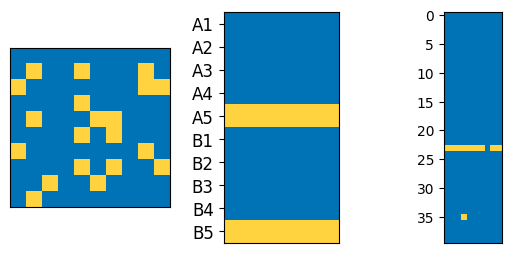

In [ ]:
semantic_charge = 2
mtl_sparsity = (semantic_charge/network.max_semantic_charge_input)*network.mtl_sparsity.clone()
mtl = network.pattern_complete('mtl', h_0=h_random, sparsity=mtl_sparsity)


ctx_hat = F.linear(mtl, network.ctx_mtl) + network.ctx_b*network.ctx_IM
ctx, _ = network.activation(network.ctx_hat, 'ctx', sleep=True, subregion_index=1)



fig, ax = plt.subplots(1, 3, figsize=(7, 3))
ax[0].imshow(mtl[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl[100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx[network.ordered_indices_ctx_episodes].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)


plt.savefig('Figures_SVG/7b3.svg', dpi=300, transparent=True)

In [ ]:
    def mtl_generate(self, semantic_charge, num_iterations=None):
        num_iterations = num_iterations  if num_iterations != None else getattr(self, 'mtl_generate_pattern_complete_iterations')
        mtl_sparse_sparsity = (semantic_charge/self.max_semantic_charge_input)*self.mtl_sparse_sparsity.clone()
        h_random_sparse = torch.randn(self.mtl_sparse_size)
        h_sparse = self.pattern_complete('mtl_sparse', h_0=h_random_sparse, num_iterations=num_iterations, sparsity=mtl_sparse_sparsity)
        mtl_sparsity = (semantic_charge/self.max_semantic_charge_input)*self.mtl_sparsity.clone()
        h_conditioned = torch.zeros(self.mtl_size)
        h_conditioned[self.mtl_dense_size:] = h_sparse
        h_random = torch.randn(self.mtl_size)
        #h_random[self.mtl_dense_size:] = h_sparse
        h = self.pattern_complete('mtl', h_0=h_random, h_conditioned=None, num_iterations=num_iterations, sparsity=mtl_sparsity)
        return h

In [86]:
ordered_indices_ctx, ordered_indices_mtl, ordered_indices_mtl_dense, ordered_indices_mtl_sparse, selectivity_ctx, selectivity_mtl, selectivity_mtl_dense, selectivity_mtl_sparse, accuracy_A, accuracy_B = get_selectivity_accuracy(network, input_latents, input_episodes, input_params, latent_specs)

torch.Size([350, 8000]) torch.Size([8000, 10])
No selective neurons in mtl_sparse, cannot compute accuracy.


In [45]:
X_sen = torch.stack(network.activity_recordings["sen"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

X_episodes = F.one_hot(input_episodes[-100:].long(), num_classes=np.prod(latent_specs["dims"]))


network.selectivity_ctx, network.ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, threshold=0.7)
network.selectivity_mtl_sparse, network.ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, threshold=0.7)
network.selectivity_mtl_dense, network.ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, threshold=0.7)


network.selectivity_ctx_episodes, network.ordered_indices_ctx_episodes = get_ordered_indices(X_ctx, X_episodes, threshold=0.7)

In [109]:
X_ctx.shape

torch.Size([8000, 350])

In [9]:
selectivity_mtl_sparse.max(axis=1)

torch.return_types.max(
values=tensor([   nan,    nan, 0.8931, 0.9056, 0.9221,    nan,    nan, 0.9447, 0.9508,
        0.8931, 0.9447, 0.6676, 0.9447, 0.9508,    nan,    nan, 0.9221,    nan,
        0.9221,    nan, 0.6676,    nan, 0.8931, 0.8898,    nan,    nan,    nan,
           nan,    nan, 0.9833,    nan, 0.9508,    nan, 0.8945, 0.8898, 0.9341,
           nan, 0.9221, 0.9056, 0.8945,    nan, 0.9056,    nan, 0.8945,    nan,
           nan,    nan,    nan,    nan,    nan,    nan, 0.9833,    nan, 0.9221,
           nan,    nan, 0.8898, 0.8898, 0.9447,    nan,    nan, 0.8945, 0.9833,
           nan, 0.9341, 0.8945,    nan,    nan, 0.8931, 0.9341,    nan, 0.6676,
           nan,    nan,    nan,    nan,    nan, 0.9341,    nan, 0.9833, 0.6676,
           nan,    nan, 0.6676, 0.8898, 0.9341,    nan, 0.9056,    nan, 0.9508,
           nan,    nan,    nan, 0.8931, 0.9508,    nan, 0.9833,    nan, 0.9447,
        0.9056]),
indices=tensor([0, 0, 5, 4, 1, 0, 0, 7, 6, 5, 7, 2, 7, 6, 0, 0, 1, 0, 1

(array([23.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([-0.06758181,  0.00669463,  0.08097108,  0.15524752,  0.22952397,
         0.3038004 ,  0.37807685,  0.4523533 ,  0.52662975,  0.60090619,
         0.67518264]),
 <BarContainer object of 10 artists>)

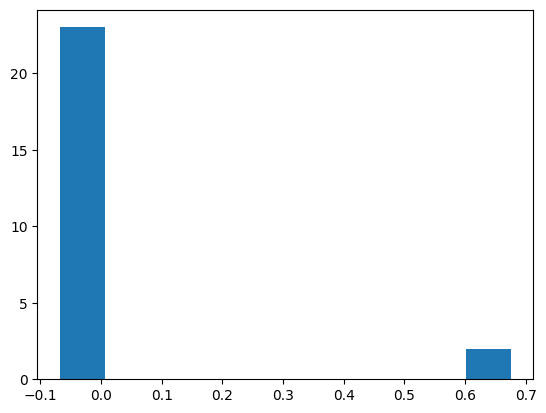

In [ ]:
plt.hist(network.selectivity_ctx_episodes[110])

In [132]:
torch.topk(network.selectivity_ctx_episodes.max(axis=1)[0], k=250)[1]

tensor([180, 208, 275, 283, 292, 303, 380, 177, 130, 349, 248, 261, 270, 382,
        193, 375, 160, 169, 332, 351, 133, 342, 279, 204, 198, 152, 155, 308,
        173, 100, 390, 181, 282, 231, 166, 327, 364, 245, 345, 325, 170, 264,
        373, 271, 368, 182, 391, 183, 195, 184, 220, 240, 109, 257, 347, 272,
        129, 369, 194, 296, 365, 285, 103, 362, 249, 206, 367, 236, 148, 134,
        298, 301, 127, 164, 179, 209, 266, 323, 263, 117, 328, 243, 113, 286,
        136, 210, 219, 171, 290, 125, 145, 392, 131, 191, 144, 359, 374, 354,
        381, 288, 111, 135, 269, 313, 280, 244, 178, 154, 138, 255, 336, 355,
        187, 188, 218, 228, 393, 238, 267, 307, 348, 356, 200, 222, 163, 289,
        384, 372, 340, 358, 387, 128, 324, 190, 167, 306, 150, 276, 300, 229,
        314, 352, 247, 333, 108, 192, 146, 350, 366, 343, 175, 305, 158, 260,
        174, 284, 339, 299, 102, 185, 386, 396, 281, 241, 310, 106, 213, 110,
        143, 312, 232, 234, 132, 273, 258, 197, 189, 293, 256, 1

In [127]:
torch.topk(network.selectivity_ctx_episodes.max(axis=1)[0], k=251)[1]

tensor([180, 275, 349, 283, 177, 380, 208, 303, 292, 130, 169, 270, 351, 160,
        261, 382, 248, 375, 332, 193, 342, 173, 133, 204, 198, 152, 155, 308,
        279, 231, 327, 100, 390, 181, 282, 166, 182, 345, 271, 264, 245, 170,
        364, 368, 325, 373, 391, 195, 184, 183, 272, 240, 109, 194, 369, 347,
        296, 257, 129, 220, 285, 148, 362, 249, 103, 206, 236, 365, 134, 367,
        209, 266, 263, 117, 179, 298, 301, 164, 323, 127, 243, 286, 328, 113,
        125, 219, 136, 210, 290, 171, 145, 191, 288, 354, 374, 111, 144, 381,
        392, 359, 131, 135, 313, 244, 280, 178, 269, 154, 187, 138, 336, 188,
        355, 218, 255, 393, 228, 307, 267, 348, 238, 356, 222, 200, 289, 163,
        384, 372, 167, 387, 190, 128, 306, 276, 340, 358, 150, 324, 300, 229,
        314, 352, 192, 333, 108, 247, 146, 158, 305, 284, 339, 343, 350, 366,
        260, 175, 174, 299, 102, 396, 110, 386, 185, 143, 310, 213, 281, 241,
        106, 312, 197, 234, 232, 256, 189, 258, 273, 293, 132, 1

array([ 0.,  0.,  1.,  1.,  0.,  0.,  1., 22., 19., 38., 52., 30., 33.])

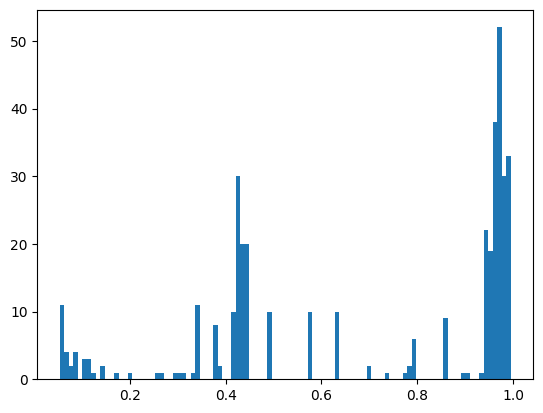

In [ ]:
plt.hist(network.selectivity_ctx_episodes[network.ordered_indices_ctx_episodes].max(axis=1)[0], bins=100)[0][-13:]

197.0

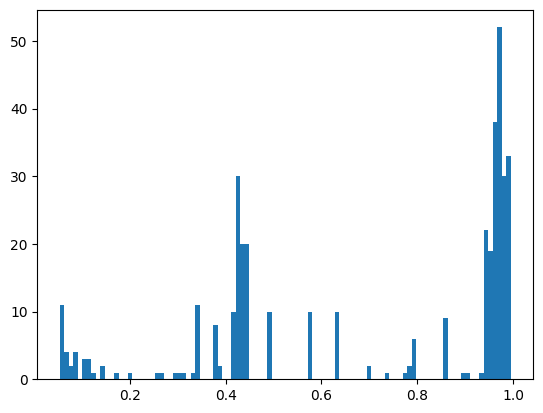

In [41]:
plt.hist(network.selectivity_ctx_episodes[network.ordered_indices_ctx_episodes].max(axis=1)[0], bins=100)[0][-13:].sum()

(array([ 34.,   0.,   2.,  50.,  50.,   0.,   0.,   0.,   0., 250.]),
 array([0.05431874, 0.14825591, 0.24219309, 0.33613026, 0.43006742,
        0.52400458, 0.61794174, 0.7118789 , 0.80581611, 0.89975327,
        0.99369043]),
 <BarContainer object of 10 artists>)

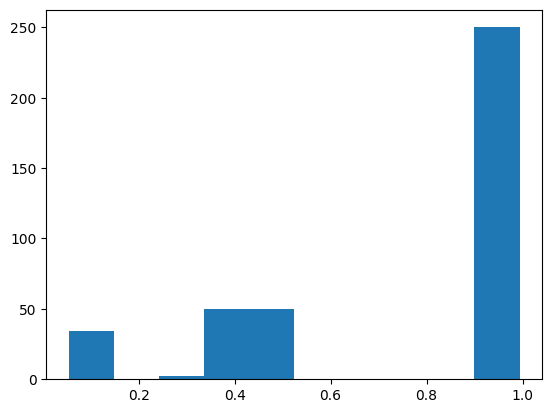

In [ ]:
plt.hist(network.selectivity_ctx_episodes[network.ordered_indices_ctx_episodes].max(axis=1)[0])

In [75]:
def get_selectivity(recordings, latents):
    # Flatten time
    _, num_neurons = recordings.shape


    days, day_length, num_latents = latents.shape

    recordings_flat = recordings.reshape(-1, num_neurons).float()    # shape: (days * day_length, num_neurons)
    latents_flat = latents.reshape(-1, num_latents).float()    # shape: (days * day_length, num_latents)


    # Normalize (zero mean, unit variance)
    latents_norm = (latents_flat - latents_flat.mean(dim=0)) / latents_flat.std(dim=0)
    recordings_norm = (recordings_flat - recordings_flat.mean(dim=0)) / recordings_flat.std(dim=0)


    # Compute correlation (selectivity): (num_neurons, num_latents)
    selectivity = recordings_norm.T @ latents_norm / latents_norm.shape[0]


    return selectivity



def get_ordered_indices(recordings, latents, threshold=0.9):
    selectivity = get_selectivity(recordings, latents)
    num_neurons, num_latents = selectivity.shape

    # Identify the latent with the highest selectivity per neuron
    max_selectivity, max_latent_idx = selectivity.max(dim=1)

    # Assign neurons to latents if selectivity >= threshold, else assign -1 (non-selective)
    assigned_latents = torch.where(max_selectivity >= threshold, max_latent_idx, -1)

    print(assigned_latents.shape)

    # Generate reordered indices
    ordered_indices = []

    # Iterate over each latent to collect selective neurons
    for latent in range(num_latents):
        latent_neurons = (assigned_latents == latent).nonzero(as_tuple=True)[0]
        ordered_indices.append(latent_neurons)

    # Add non-selective neurons at the end
    non_selective_neurons = (assigned_latents == -1).nonzero(as_tuple=True)[0]
    ordered_indices.append(non_selective_neurons)

    # Concatenate indices into a single ordering
    ordered_indices = torch.cat(ordered_indices)

    return selectivity, ordered_indices

In [76]:

network.selectivity_ctx_episodes, network.ordered_indices_ctx_episodes = get_ordered_indices(X_ctx, X_episodes, threshold=0.5)

torch.Size([350])


In [81]:
network.ordered_indices_ctx_episodes[230]

tensor(22)

In [150]:
torch.topk(network.selectivity_ctx_episodes[:, 17], k=17, sorted=True)

torch.return_types.topk(
values=tensor([0.8996, 0.8178, 0.8159, 0.8100, 0.8042, 0.7639, 0.7443, 0.7303, 0.7259,
        0.7129, 0.6832, 0.6270, 0.5888, 0.5755, 0.5300, 0.5300, 0.5098]),
indices=tensor([321, 259, 319, 142, 237, 337, 334, 123, 360, 329, 287, 377, 246, 338,
        326, 216, 217]))

In [58]:
network.selectivity_ctx_episodes[65].max()

tensor(0.4880)

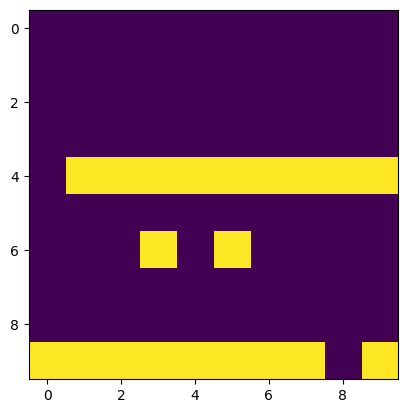

In [101]:
plt.imshow(X_sen[130].reshape((-1, 10)))

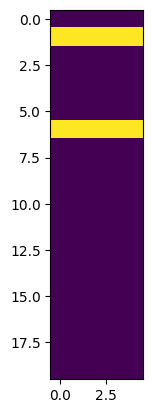

In [113]:
plt.imshow(X_mtl_sparse[-1][ordered_indices_mtl_sparse].reshape((-1, 5)))

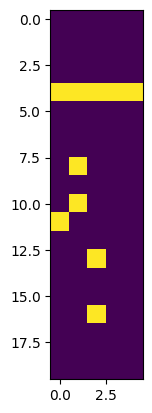

In [112]:
plt.imshow(X_mtl_sparse[-1][network.ordered_indices_mtl_sparse].reshape((-1, 5)))

In [86]:
mtl = torch.stack(network.activity_recordings["mtl"], axis=0)[network.sleep_indices_A][0]


tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

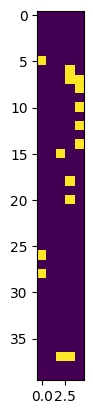

In [94]:
plt.imshow(mtl.reshape((-1,5)))

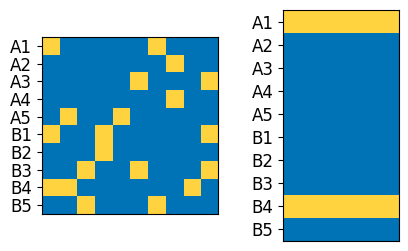

In [ ]:
mtl = torch.stack(network.activity_recordings["mtl"], axis=0)[network.sleep_indices_A][3]
fig, ax = plt.subplots(1, 2, figsize=(5, 3))
ax[0].imshow(mtl[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(mtl[100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]
ax[0].set_yticks(positions, labels, fontsize=12)
ax[1].set_yticks(positions, labels, fontsize=12)

plt.savefig('Figures_SVG/4b.svg', dpi=300, transparent=True)

In [28]:
ctx_hat = torch.stack(network.activity_recordings["ctx_hat"], axis=0)[network.sleep_indices_A][3]

In [12]:
torch.sort(ctx_hat)[0][-20:]

tensor([0.7540, 0.7540, 0.7542, 0.7542, 0.7542, 0.7544, 0.7545, 0.7545, 0.7545,
        0.7546, 0.7549, 0.7550, 0.7551, 0.7555, 0.7556, 0.7563, 0.7564, 0.7569,
        0.7579, 0.7581])

(array([93., 65.,  1., 21., 31., 19., 10.,  0.,  0., 10.]),
 array([0.00140877, 0.00406166, 0.00671456, 0.00936745, 0.01202034,
        0.01467323, 0.01732613, 0.01997902, 0.02263191, 0.0252848 ,
        0.0279377 ]),
 <BarContainer object of 10 artists>)

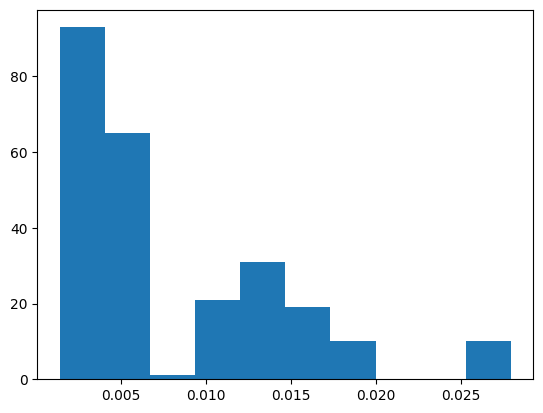

In [52]:
plt.hist(F.linear(network.ctx_mtl, network.ctx_mtl[347])[100:)

tensor([321, 259, 319, 142, 237, 337, 334, 123, 360, 329, 287, 377, 246, 338,
        326, 216, 217])

In [152]:
ctx_mtl = torch.stack(network.connectivity_recordings["ctx_mtl"], axis=1)



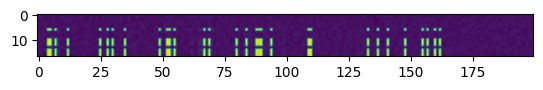

In [ ]:
plt.imshow(ctx_mtl[torch.topk(network.selectivity_ctx_episodes[:, 17], k=17, sorted=True)[1]][:, 1000])

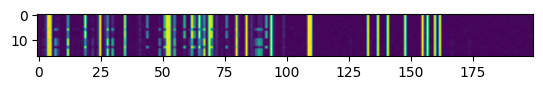

In [170]:
plt.imshow(ctx_mtl[torch.topk(network.selectivity_ctx_episodes[:, 17], k=17, sorted=True)[1]][:, 50000])

In [64]:
ctx_mtl[242][1].shape

torch.Size([50001, 200])

In [66]:
ctx_mtl[242][0].shape

torch.Size([200])

In [ ]:
50001

In [ ]:
5

In [ ]:
plt.imshow(ctx_mtl[110][50000]:][network.ordered_indices_mtl_sparse].reshape((-1, 5)))

AttributeError: 'SSCNetwork' object has no attribute 'ordered_indices_mtl_sparse'

In [ ]:
259, 319, 142, 157, 237, 330, 317, 371, 153, 337, 334, 123, 360, 329

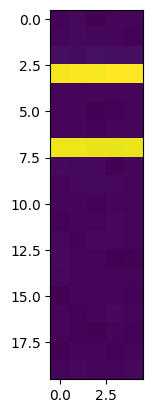

In [151]:
plt.imshow(network.ctx_mtl[217][100:][network.ordered_indices_mtl_sparse].reshape((-1, 5)))
#plt.yticks(positions, labels, fontsize=12)

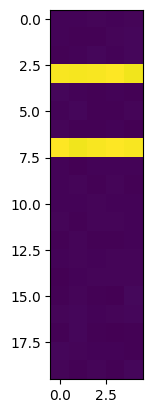

In [130]:
plt.imshow(network.ctx_mtl[319][100:][network.ordered_indices_mtl_sparse].reshape((-1, 5)))
#plt.yticks(positions, labels, fontsize=12)

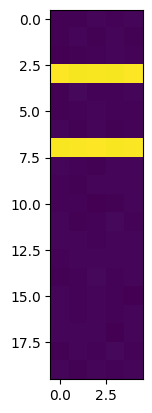

In [131]:
plt.imshow(network.ctx_mtl[259][100:][network.ordered_indices_mtl_sparse].reshape((-1, 5)))


(array([ 8.,  9., 21., 31., 52., 31., 32., 10.,  5.,  1.]),
 array([-0.0125051 , -0.00968778, -0.00687046, -0.00405314, -0.00123582,
         0.0015815 ,  0.00439882,  0.00721614,  0.01003345,  0.01285077,
         0.01566809]),
 <BarContainer object of 10 artists>)

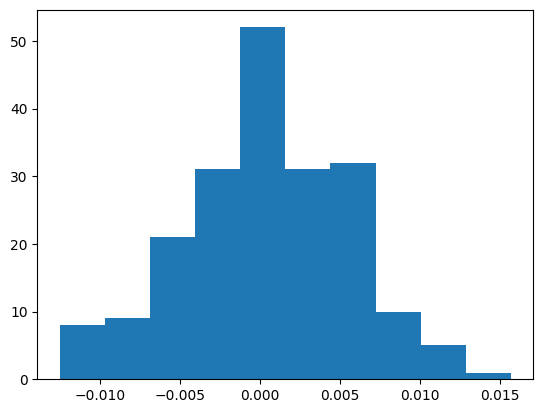

In [131]:
plt.hist(network.ctx_mtl[158].flatten())

(array([18., 78., 63.,  9.,  2.,  1.,  1.,  9., 13.,  6.]),
 array([-0.00794494, -0.00340182,  0.0011413 ,  0.00568442,  0.01022755,
         0.01477067,  0.01931379,  0.02385691,  0.02840003,  0.03294314,
         0.03748627]),
 <BarContainer object of 10 artists>)

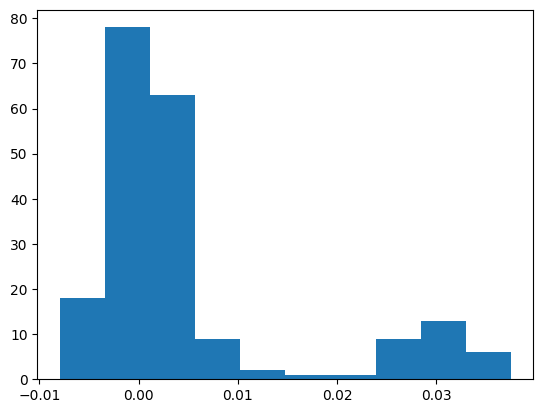

In [ ]:
plt.hist(network.ctx_mtl[158].flatten())

In [62]:
torch.sort(ctx_hat)[0][-10:]

tensor([0.9193, 0.9293, 0.9890, 1.0057, 1.0067, 1.0500, 1.0547, 1.0553, 1.0563,
        1.0579])

In [74]:
network.ctx_mtl[269] 

tensor(1.)

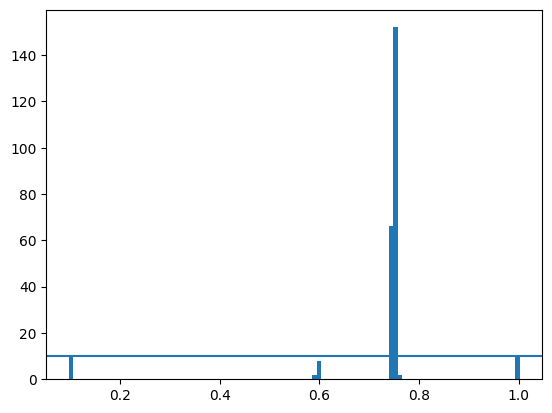

In [ ]:
plt.hist(ctx_hat[100:].flatten(), bins=100)
plt.axhline(10)

In [58]:
torch.argsort(ctx_hat)

tensor([ 39,  80,   3,  40,  58,  37,   2,  27,  74,  49,  76,  25,  19,  31,
         52,  72,  95,  47,  79,   5,  11,  17,  81,  15,  44,  51,   9,  75,
         43,  23,  35,  61,  24,  77,  50,  18,  57,  59,   1,  46,  65,  32,
         33,  83,  53,  29,  82,  84,  22,  85,  69,  16,  89,  12,   0,   6,
         92,  38,  48,  99,  64,  97,  78,  30,  87,  28,   7,  63,  62,  96,
         14,  73,  68,  90,  88,  41,  45,  56,  26,  36,  94,  42,   4,   8,
         91,  86,  60,  20,  70,  21, 120, 197, 227, 263, 321, 306, 115, 198,
        333, 220, 262, 168, 171, 308, 299, 278, 150, 146, 341, 106, 324, 277,
        176, 185, 164, 118, 200, 253, 275, 111, 288, 259, 206, 162, 144, 249,
        201, 186, 127, 295, 163, 286, 109, 211, 331, 158,  71, 175, 267,  10,
        332, 160, 112, 107, 114,  54, 192, 124,  66, 236, 230, 241, 116,  13,
         98, 139, 130, 334, 188, 305, 195, 281, 280,  93, 190, 330, 322, 229,
         34, 189,  67, 221, 119, 174, 173, 194, 290, 193, 237, 1

([<matplotlib.axis.YTick at 0x3652f5610>,
 [Text(0, 0, 'A1'),
  Text(0, 1, 'A2'),
  Text(0, 2, 'A3'),
  Text(0, 3, 'A4'),
  Text(0, 4, 'A5'),
  Text(0, 5, 'B1'),
  Text(0, 6, 'B2'),
  Text(0, 7, 'B3'),
  Text(0, 8, 'B4'),
  Text(0, 9, 'B5')])

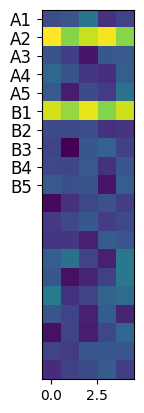

In [76]:
F.linear(network.ctx_mtl[269], mtl) + network.ctx_b[269]*network.ctx_IM[269]

tensor(0.9346)

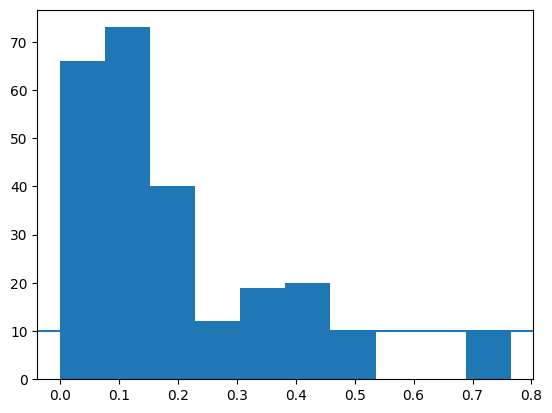

In [28]:
ctx_hat = torch.stack(network.activity_recordings["ctx_hat"], axis=0)[network.awake_indices][-10]


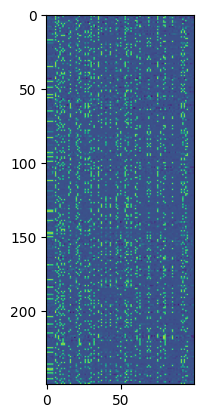

In [31]:
plt.imshow(network.ctx_mtl[100:][:, 100:][:, network.ordered_indices_mtl_sparse])

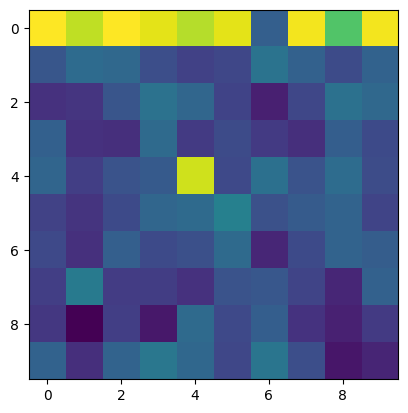

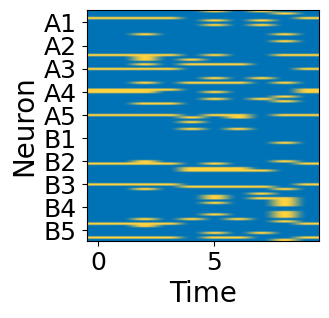

In [11]:
fig = plt.figure(figsize=(3, 3))


plt.imshow(torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A][-10:, :100].reshape(-1, 100).T, aspect='auto', cmap=blue_yellow)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5  # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 5], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.savefig('Figures_SVG/7b1.svg', dpi=300, transparent=True)

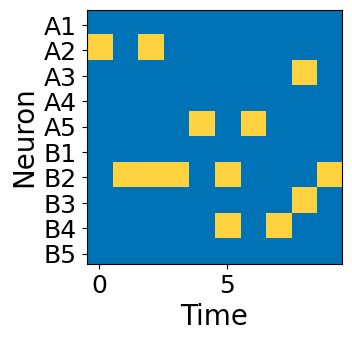

In [ ]:
fig = plt.figure(figsize=(3.3, 3.3))


plt.imshow(torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A, 100:][-10:][:, ordered_indices_mtl_sparse][:, :50].reshape((-1, 50)).T, aspect='auto', cmap=blue_yellow)
# Example parameters
N = 50  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 5], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.savefig('Figures_SVG/7b2.svg', dpi=300, transparent=True)

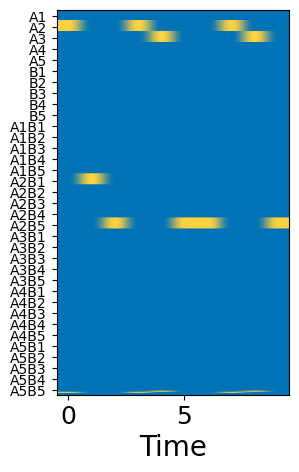

In [26]:
fig = plt.figure(figsize=(3, 5))


plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A][-10:][:, full_ordered_indices_ctx].reshape((-1, 350)).T, aspect='auto', cmap=blue_yellow)



# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]


# Example parameters
N = 250  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [100 + M * (k + 0.5) for k in range(NA * NB)]

positions.extend(positions_episodes)
labels.extend(labels_episodes)

plt.yticks(positions, labels)

plt.xticks([0, 5], fontsize=18)
plt.xlabel("Time", fontsize=20)

plt.savefig('Figures_SVG/7b3.svg', dpi=300, transparent=True)

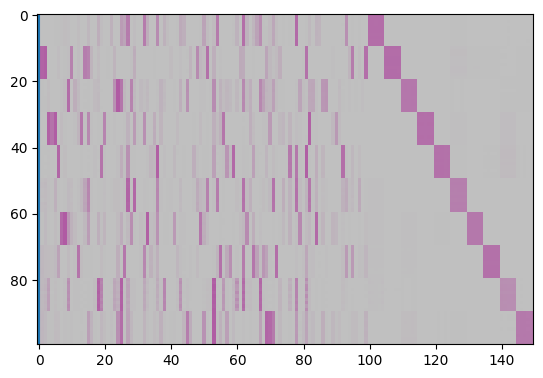

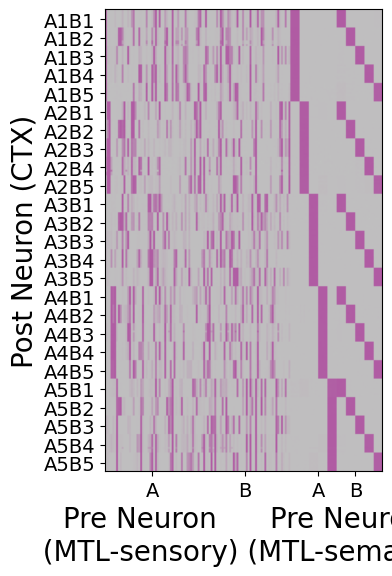

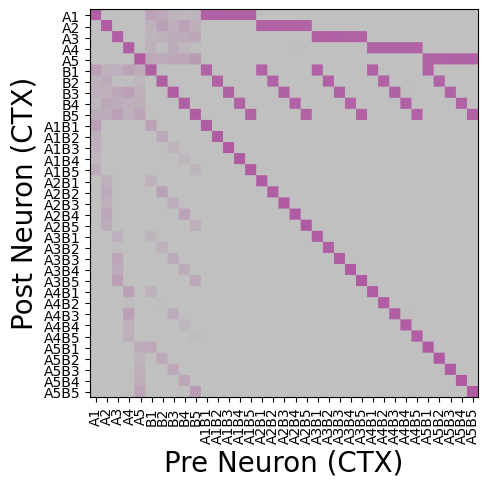

In [ ]:
network_parameters = {}

network_parameters["hebbian_filter"] = False

network_parameters["duration_phase_A"] = 500
network_parameters["duration_phase_B"] = 1000

network_parameters["sleep_duration_A"] = 10
network_parameters["sleep_duration_B"] = 10
network_parameters["reset_dayly"] = True

network_parameters["regions"] = ["sen", "mtl_sparse", "mtl_dense", "mtl", "ctx"]

network_parameters["mtl_pattern_complete_iterations"] = 10
network_parameters["mtl_dense_pattern_complete_iterations"] = 5
network_parameters["mtl_sparse_pattern_complete_iterations"] = 10
network_parameters["ctx_pattern_complete_iterations"] = 10
network_parameters["mtl_generate_pattern_complete_iterations"] = 10

network_parameters["max_semantic_charge_replay"] = 2
network_parameters["max_semantic_charge_input"] = 2

network_parameters["sen_num_subregions"] = 1
network_parameters["sen_size_subregions"] = torch.tensor([100])
network_parameters["sen_sparsity"] = torch.tensor([0.2])
network_parameters["sen_sparsity_sleep"] = torch.tensor([0.2])

network_parameters["ctx_num_subregions"] = 2
network_parameters["ctx_size_subregions"] =  torch.tensor([100, 300])
network_parameters["ctx_sparsity"] = torch.tensor([0.2, 1/30])
network_parameters["ctx_sparsity_sleep"] = torch.tensor([0.1, 1/30])

network_parameters["mtl_num_subregions"] = 2
network_parameters["mtl_size_subregions"] =  torch.tensor([100, 100])
network_parameters["mtl_sparsity"] = torch.tensor([0.2, 0.1])
network_parameters["mtl_sparsity_sleep"] = torch.tensor([0.1, 0.05])

network_parameters["mtl_dense_num_subregions"] = 1
network_parameters["mtl_dense_size_subregions"] = torch.tensor([100])
network_parameters["mtl_dense_sparsity"] = torch.tensor([0.2])
network_parameters["mtl_dense_sparsity_sleep"] = torch.tensor([0.1])

network_parameters["mtl_sparse_num_subregions"] = 1
network_parameters["mtl_sparse_size_subregions"] = torch.tensor([100])
network_parameters["mtl_sparse_sparsity"] = torch.tensor([0.1])
network_parameters["mtl_sparse_sparsity_sleep"] = torch.tensor([0.05])

network_parameters["mtl_dense_sen_projection"] = True
network_parameters["mtl_dense_sen_size"] = 30
network_parameters["max_post_mtl_dense_sen"] = 1
network_parameters["max_pre_mtl_dense_sen"] = np.inf


network_parameters["ctx_mtl_quick_lmbda"] = 1e-2
network_parameters["max_pre_ctx_mtl_quick"] = np.inf
network_parameters["max_post_ctx_mtl_quick"] = 1

network_parameters["ctx_mtl_sparsity"] = 0.5
network_parameters["ctx_mtl_mean"] = 0.03
network_parameters["ctx_mtl_std"] = 0.0005
network_parameters["ctx_mtl_lmbda"] = 5e-4
network_parameters["ctx_mtl_size"] = 2
network_parameters["max_pre_ctx_mtl"] = np.inf
network_parameters["max_post_ctx_mtl"] = 1

network_parameters["ctx_mtl_sparse_mean"] = 0.03
network_parameters["ctx_mtl_sparse_std"] = 0.005
network_parameters["ctx_mtl_sparse_lmbda"] = 1e-2
network_parameters["max_pre_ctx_mtl_sparse"] = np.inf
network_parameters["max_post_ctx_mtl_sparse"] = 1

network_parameters["ctx_mtl_dense_sparsity"] = 0.5
network_parameters["ctx_mtl_dense_g"] = 0.01

network_parameters["mtl_mtl_lmbda"] = 5e-3
network_parameters["max_pre_mtl_mtl"] = np.inf
network_parameters["max_post_mtl_mtl"] = np.inf

network_parameters["mtl_dense_mtl_dense_lmbda"] = 5e-3
network_parameters["max_pre_mtl_dense_mtl_dense"] = np.inf
network_parameters["max_post_mtl_dense_mtl_dense"] = np.inf

network_parameters["mtl_sparse_mtl_sparse_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_mtl_sparse"] = np.inf
network_parameters["max_post_mtl_sparse_mtl_sparse"] = np.inf

network_parameters["ctx_ctx_sparsity"] = 0.05
network_parameters["ctx_ctx_g"] = 1e-4
network_parameters["ctx_ctx_lmbda"] = 5e-4
network_parameters["max_pre_ctx_ctx"] = 1
network_parameters["max_post_ctx_ctx"] = np.inf

network_parameters["mtl_sparse_ctx_mean"] = 0.03
network_parameters["mtl_sparse_ctx_std"] = 0.001
network_parameters["mtl_sparse_ctx_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_ctx"] = np.inf
network_parameters["max_post_mtl_sparse_ctx"] = 1


recording_parameters = {}
recording_parameters["regions"] = ["sen", "mtl_hat", "mtl_dense", "mtl_sparse", "mtl_sparse_hat", "mtl", "ctx", "ctx_hat"]
recording_parameters["rate_activity"] = 1
#recording_parameters["connections"] = ["mtl_mtl", "ctx_mtl", "ctx_ctx", "ctx_mtl_quick", "mtl_sparse_ctx"]
recording_parameters["connections"] = ["ctx_mtl"]
recording_parameters["rate_connectivity"] = np.inf


input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4


latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
